In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from DataLoader.my_dataloader import get_loader
from DCNN.model import Model_sep, Discriminator, Model
import torch
import torch.nn as nn
from data.prepare_data import get_data_paths, read_CT_scans, missing_PTVs, read_data
import sklearn.metrics
import seaborn as sns


In [19]:
PATH = 'Output/DCNN_2ENC/best_val_evaluation_uloss.pkl'
PATH1 = 'Output/DCNN_DVHLoss1/best_val_evaluation_uloss.pkl'
PATH_OUT = 'Output/DCNN_2ENC/output'
train, val, test = get_loader(train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=True,
        seed=10,
        with_miss_PTVs=True,
        with_distance=True
    )

val_dataset = val.dataset

### Data Visualization

In [13]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(data, predicted=None):
    CT_scan = data[0][0,2]
    PTVs = data[0][0,0]
    OARs = data[0][0,1]
    Rdose = data[1][0,0]
    distance_image = data[0][0,3]
    if predicted is None: a=5 
    else: a=6
    fig, axs = plt.subplots(ncols=a, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("Distance transform")
    axs[0, 2].imshow(distance_image, cmap='jet')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')

    

    if predicted is not None:
        axs[0, 5].set_title("predicted Radiation dose")
        axs[0, 5].imshow(predicted, cmap='jet')
    plt.show()



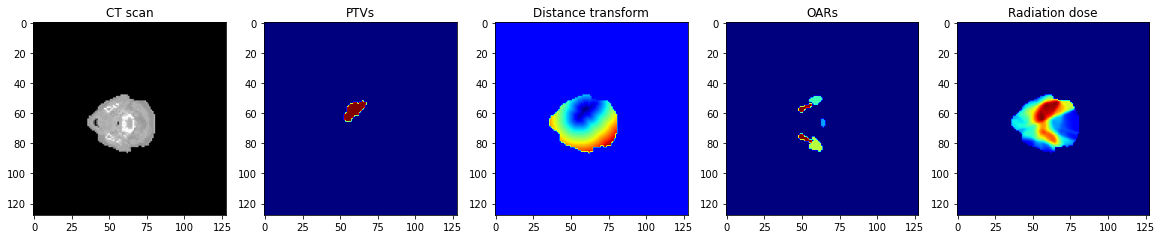

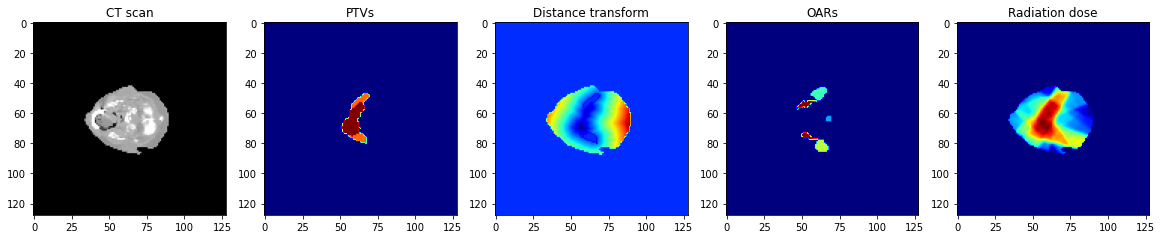

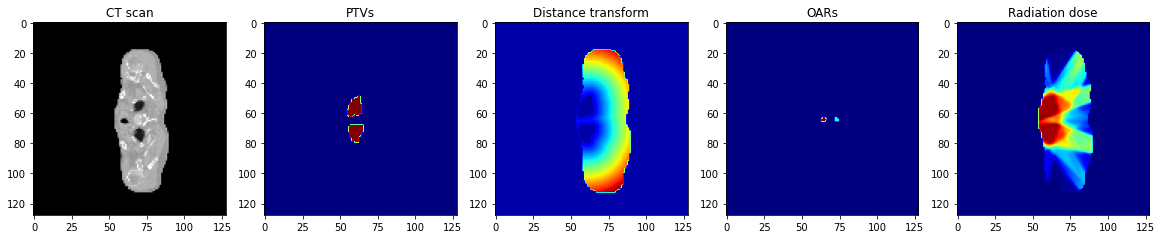

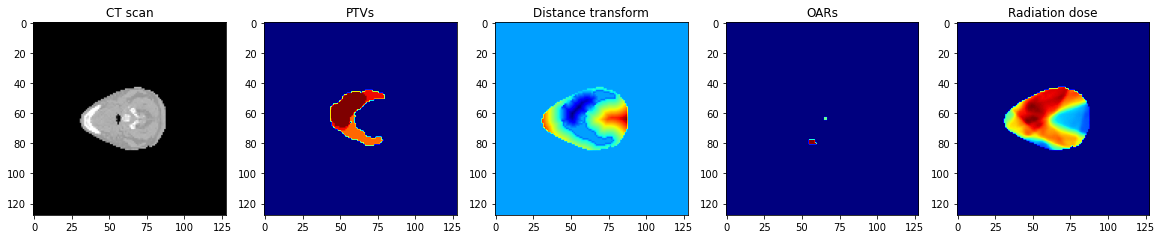

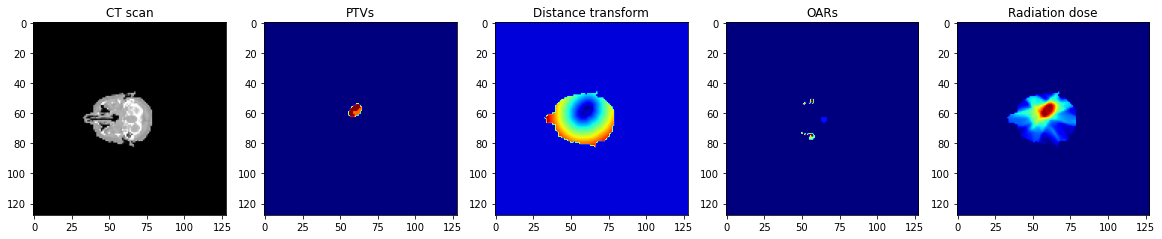

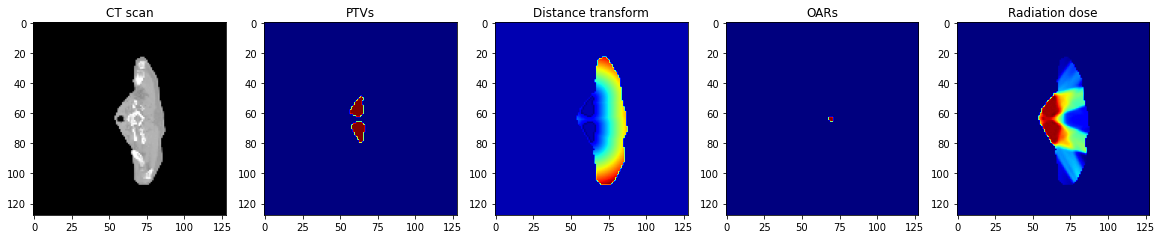

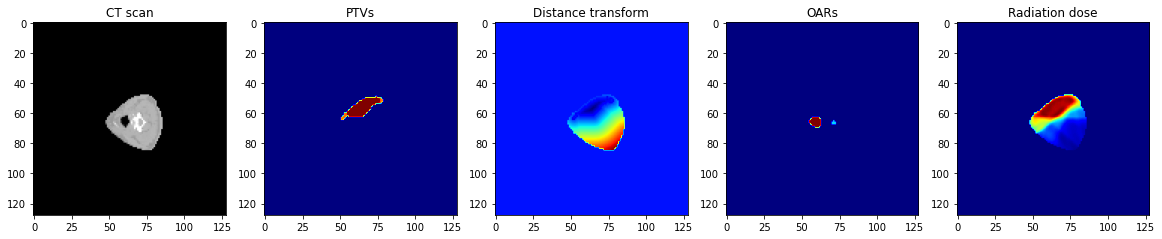

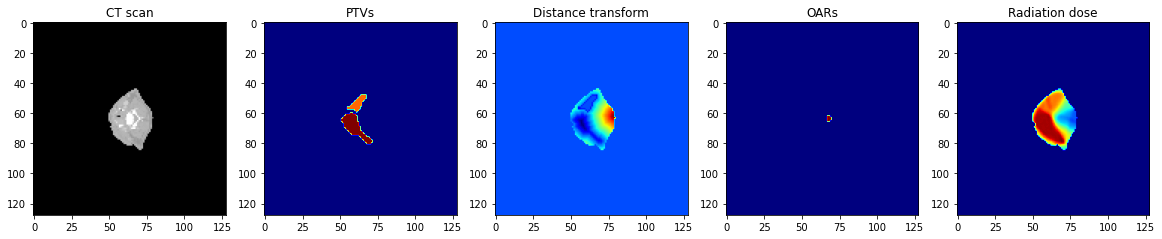

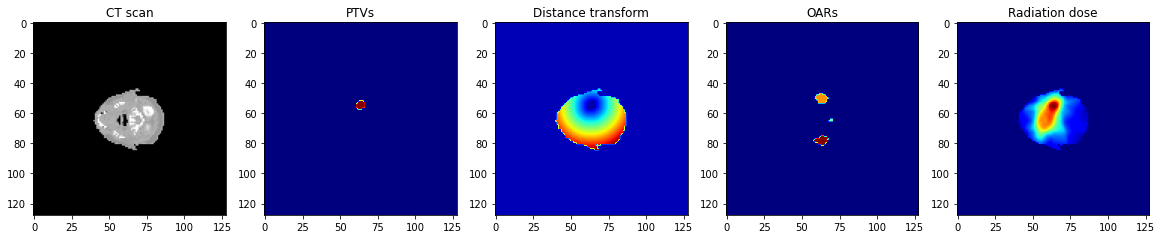

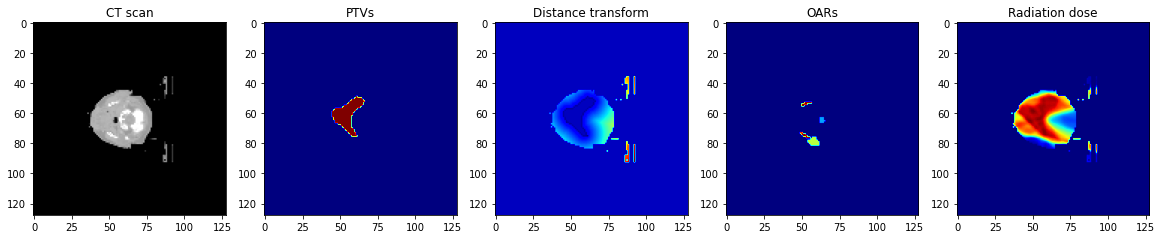

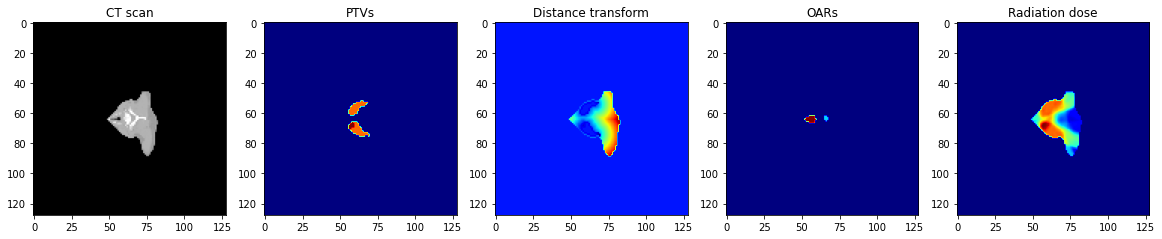

In [5]:
for batch_idx, list_loader_output in enumerate(val):
    show(list_loader_output[0]['data'])
    if batch_idx==10: break

### Missing PTVs

In [5]:
data_paths = get_data_paths(dir)
missing_indices = missing_PTVs(data_paths, indices=False)
len(missing_indices)

10200it [00:03, 3229.45it/s]


94

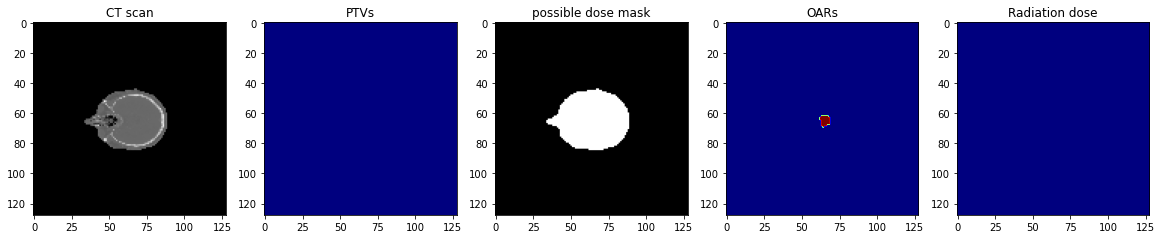

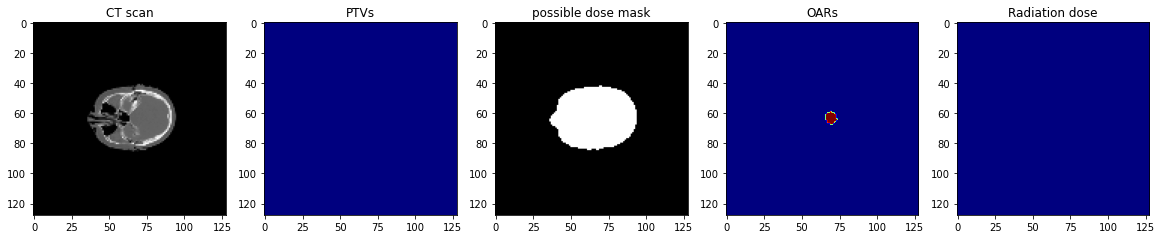

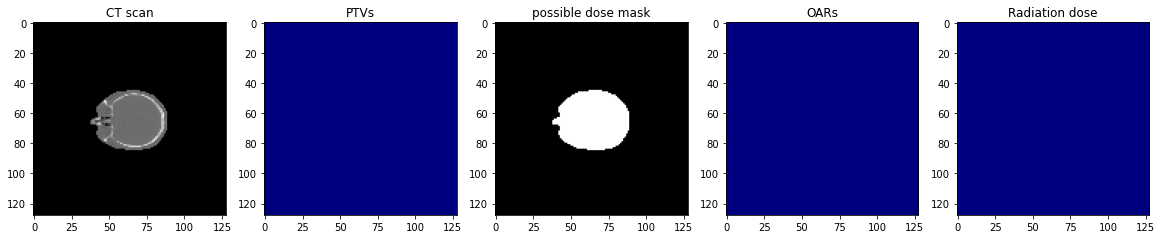

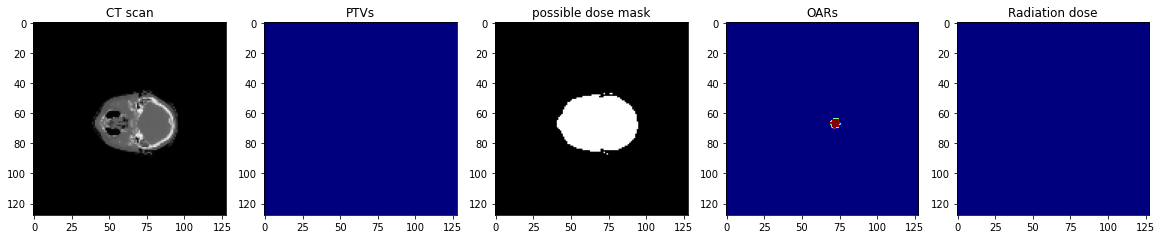

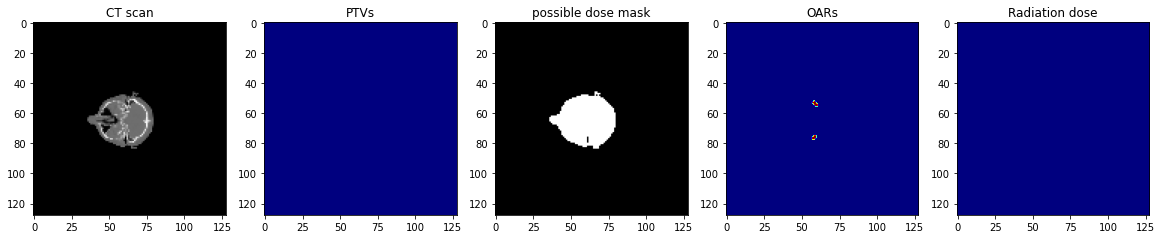

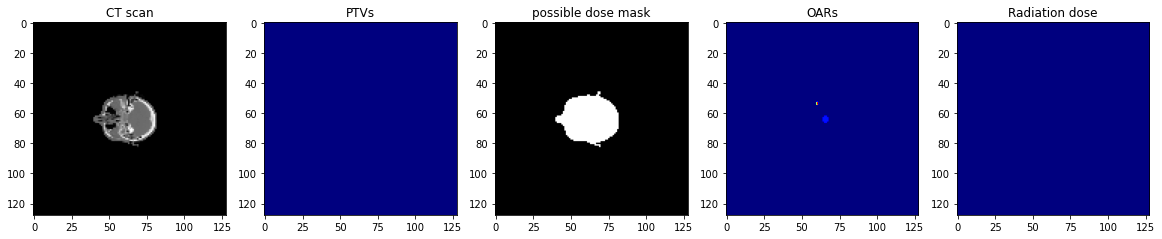

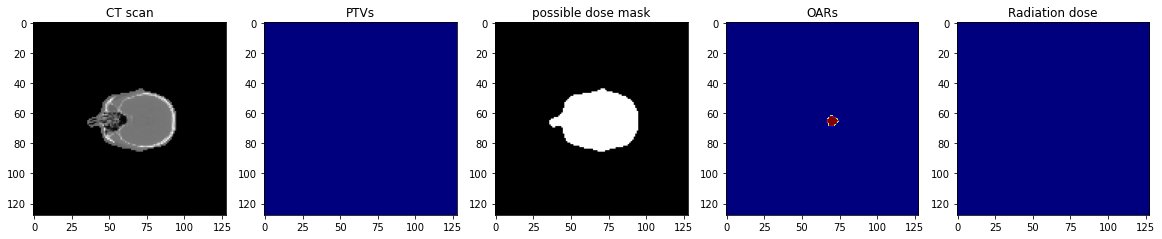

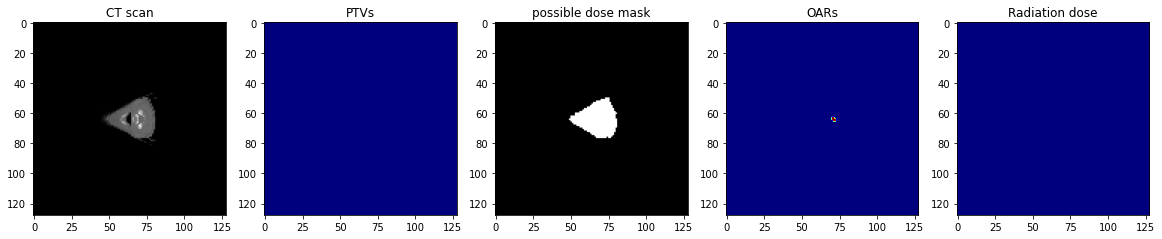

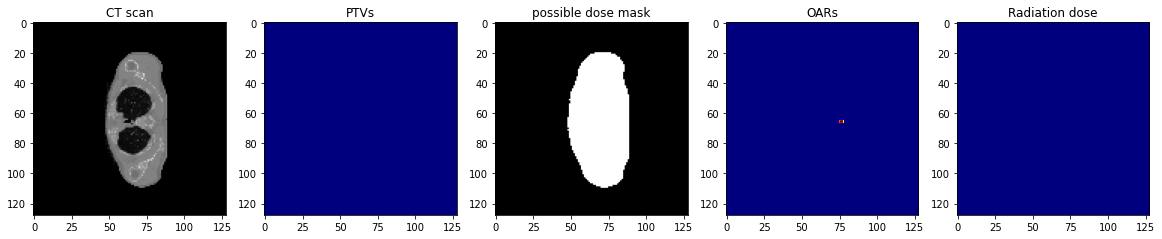

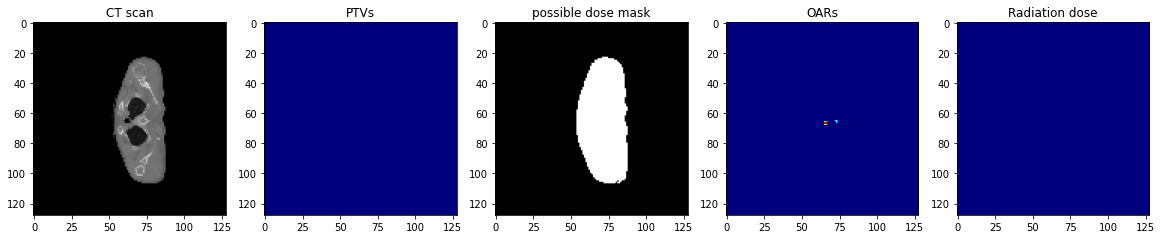

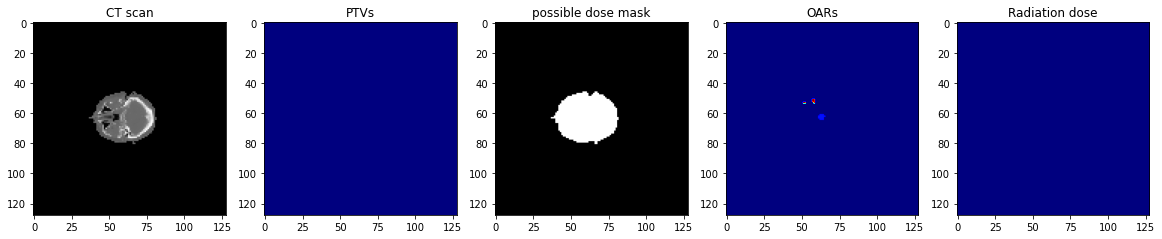

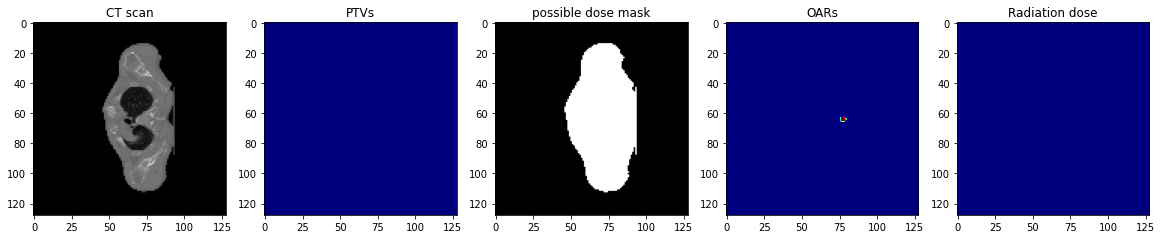

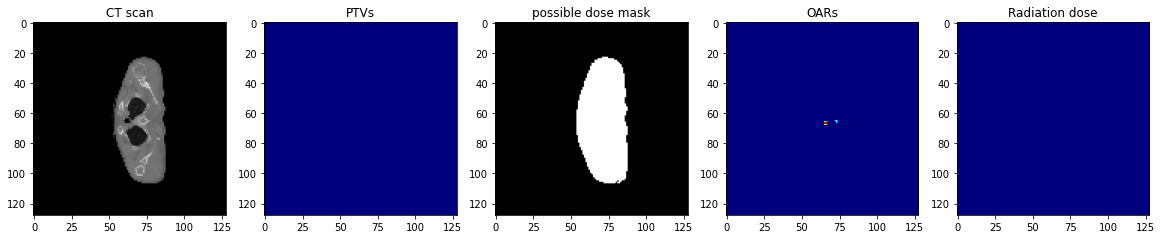

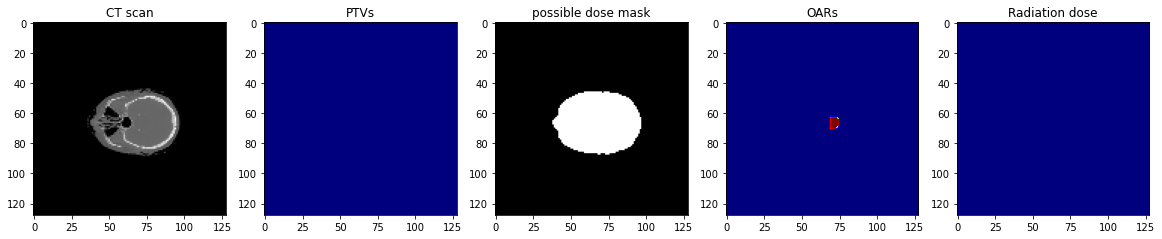

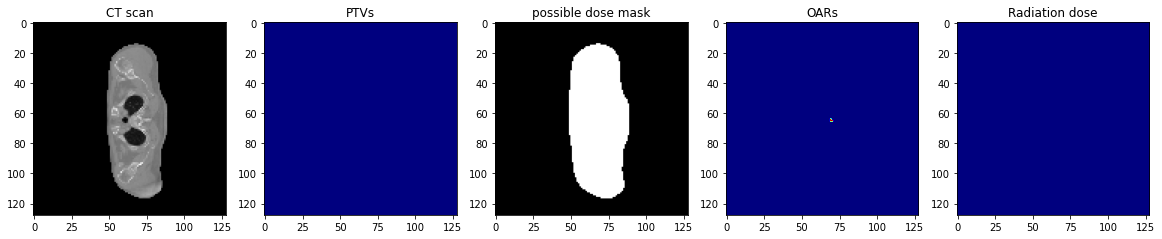

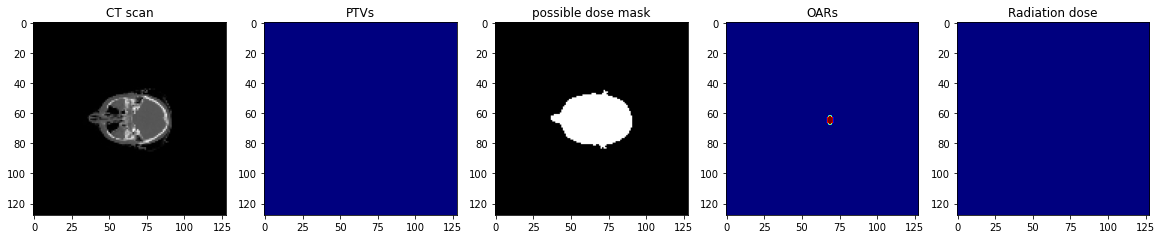

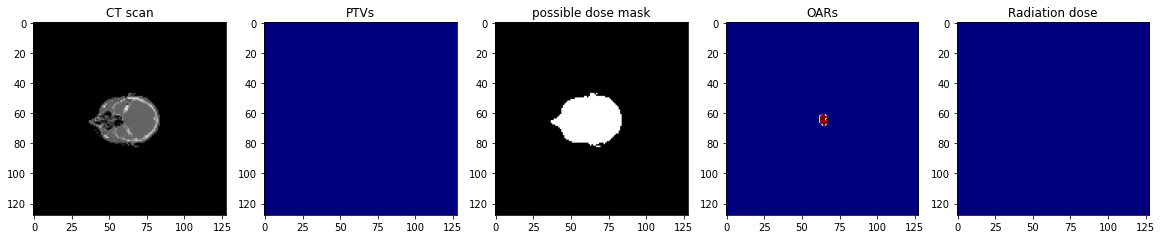

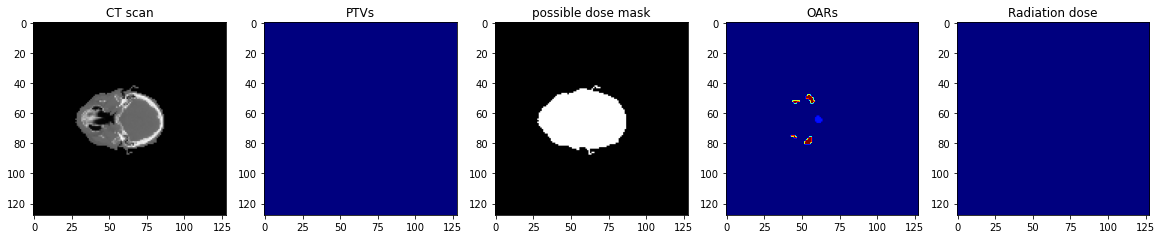

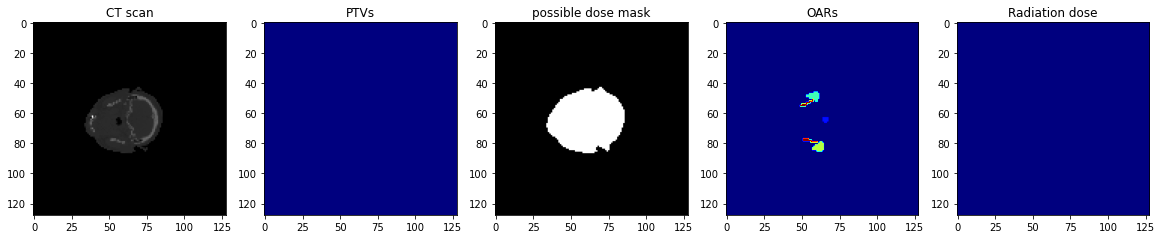

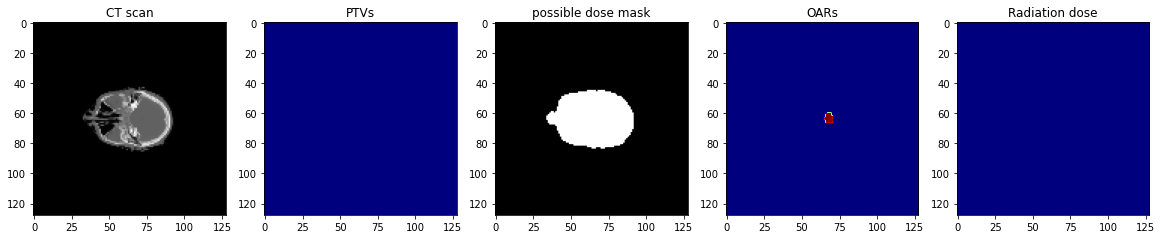

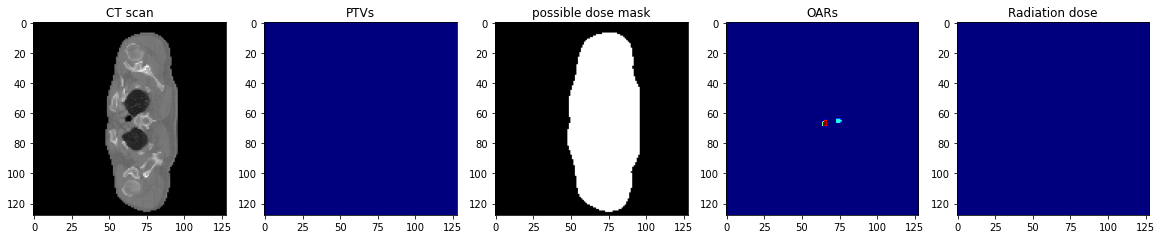

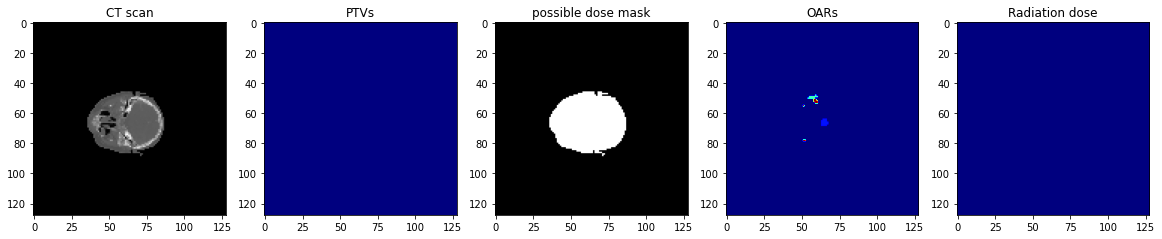

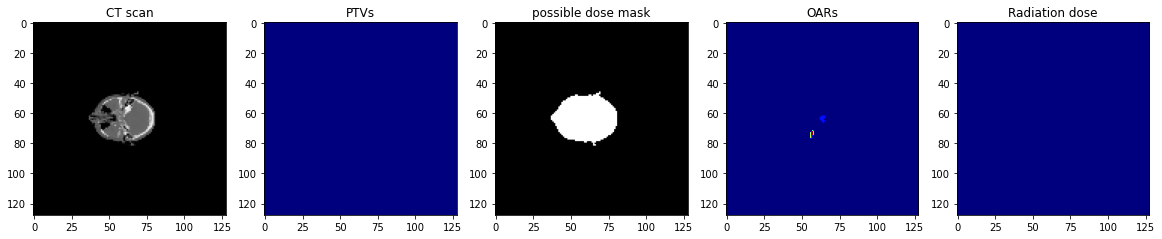

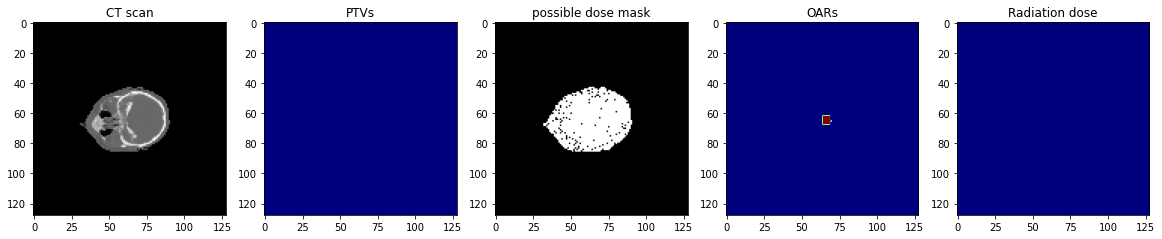

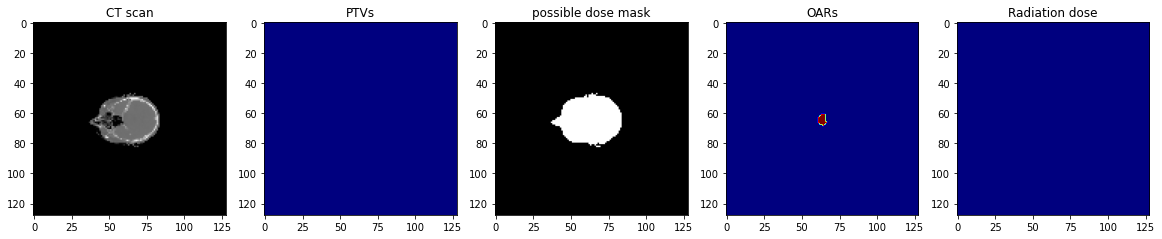

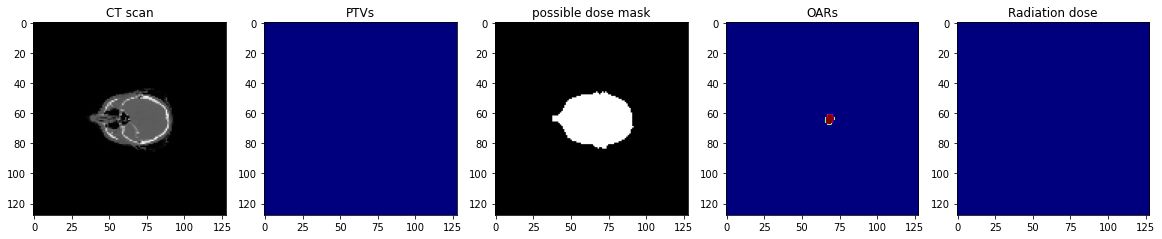

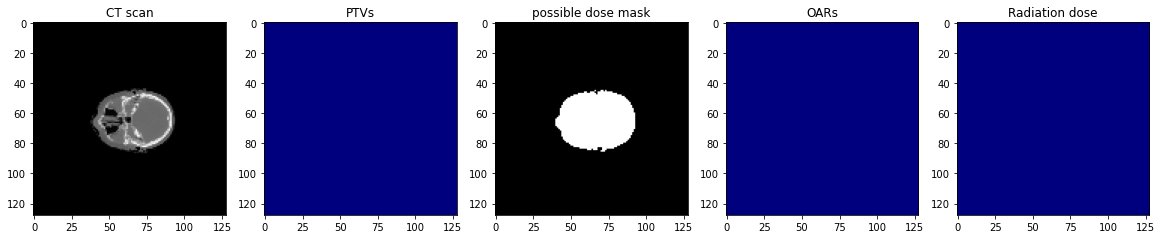

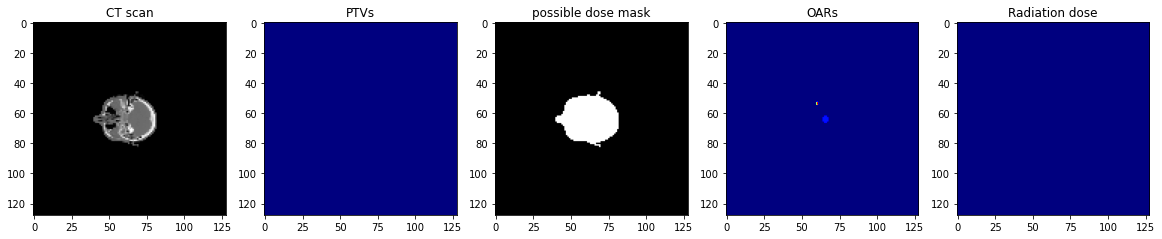

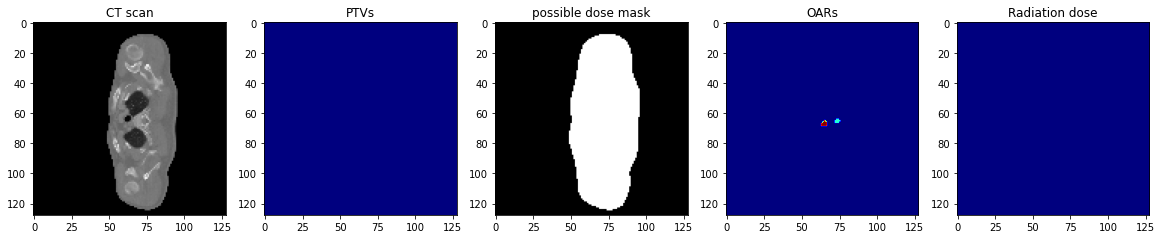

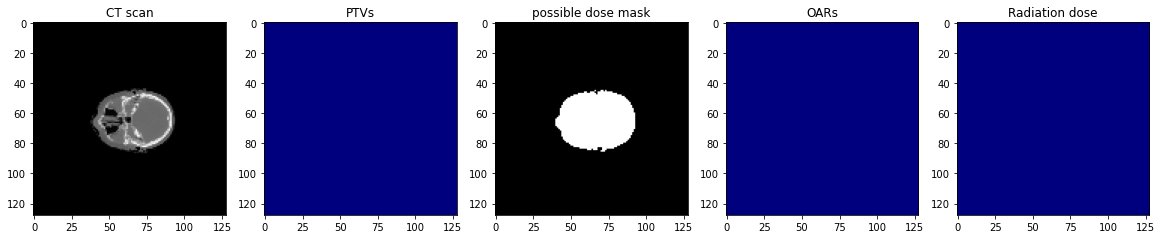

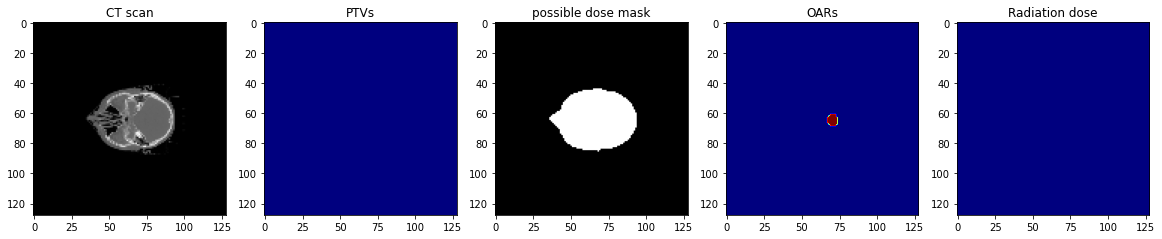

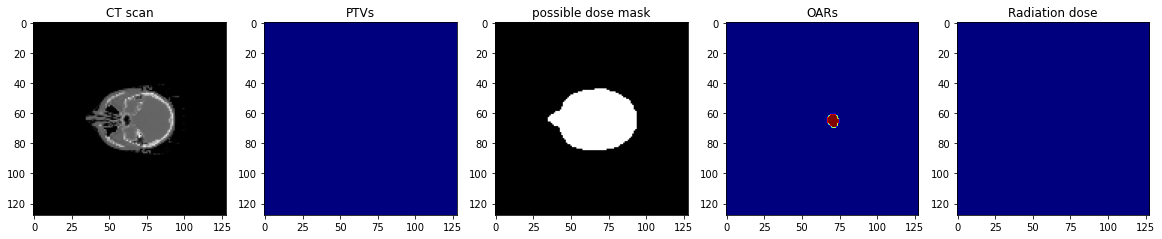

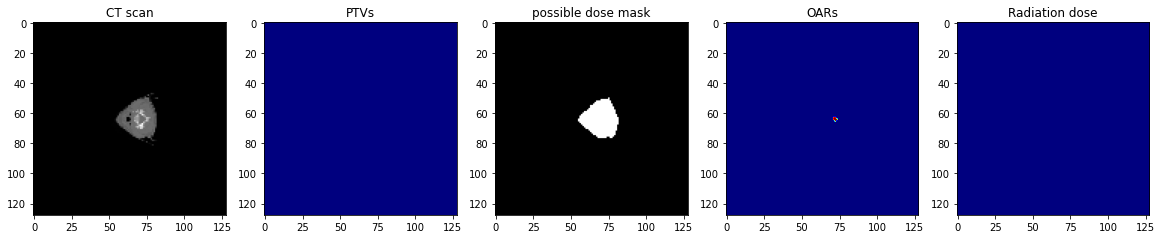

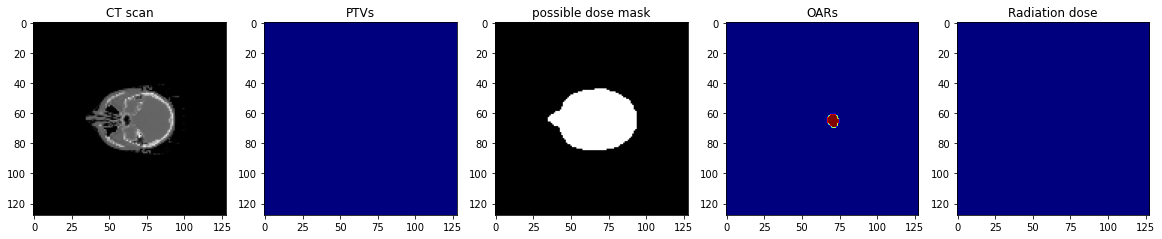

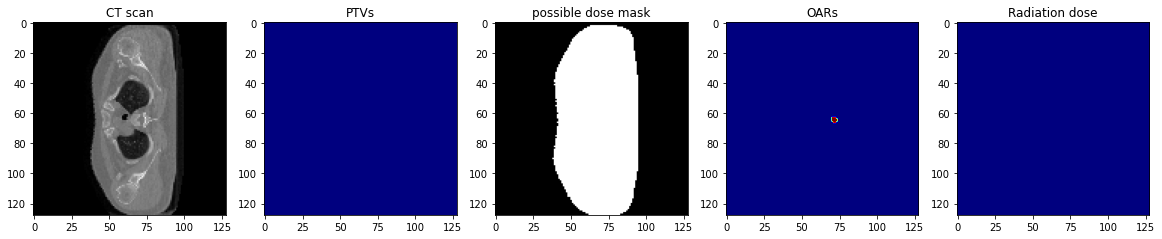

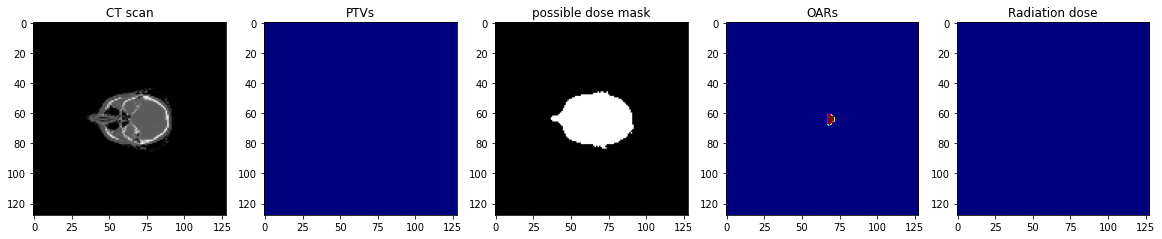

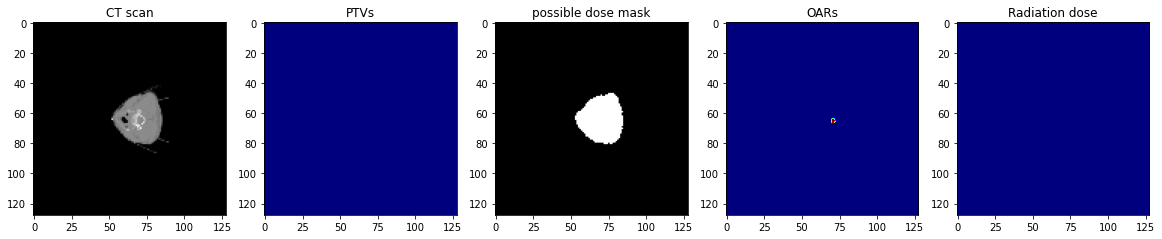

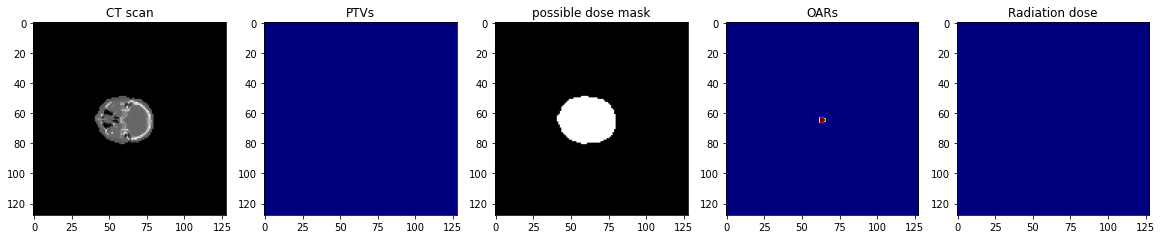

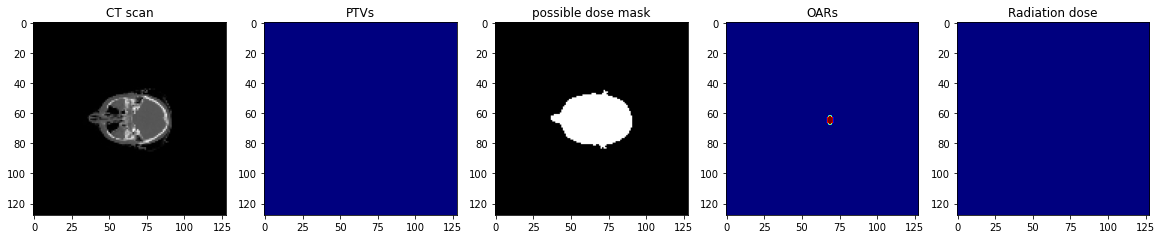

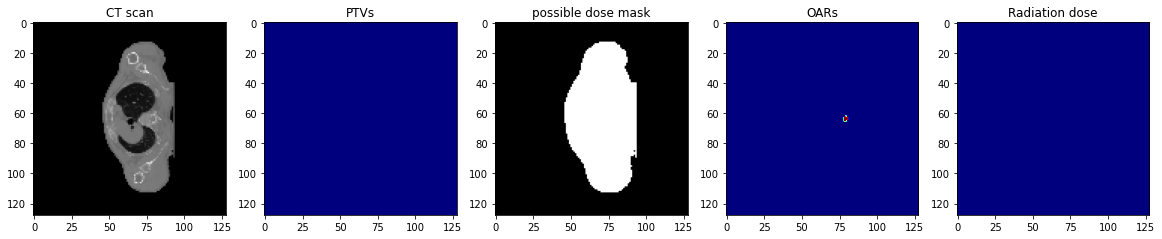

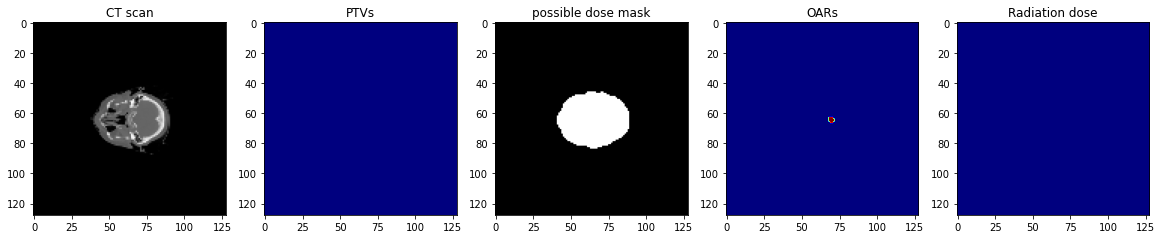

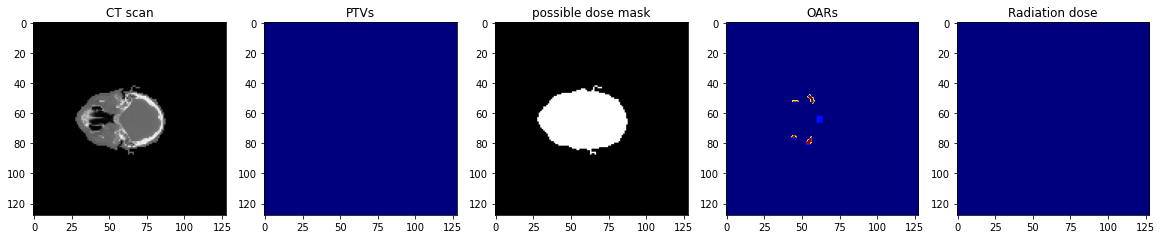

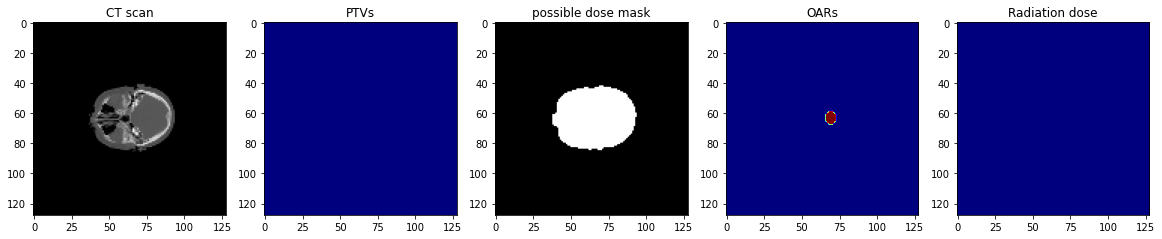

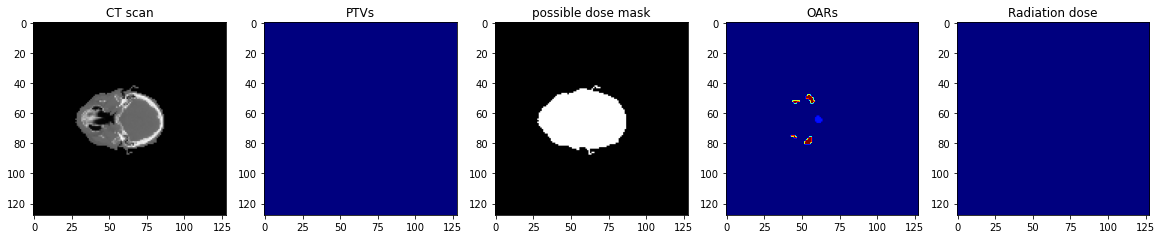

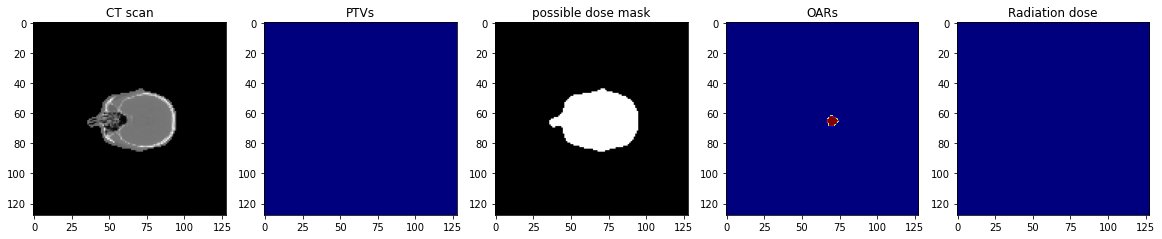

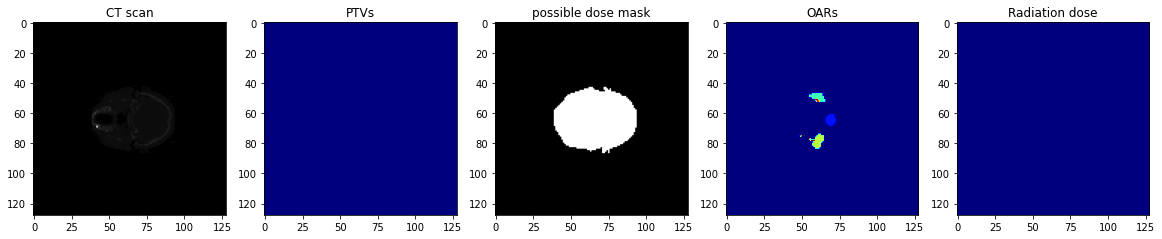

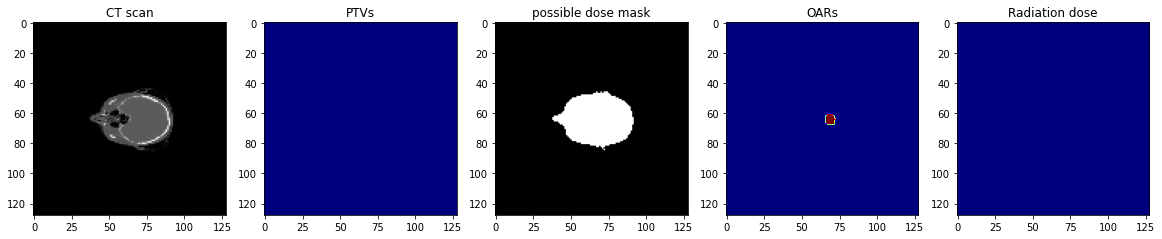

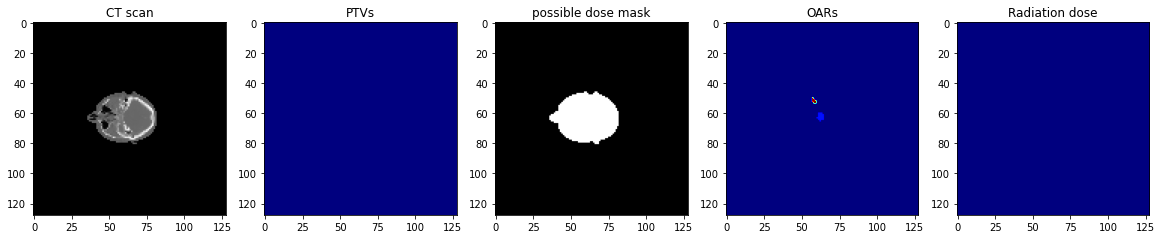

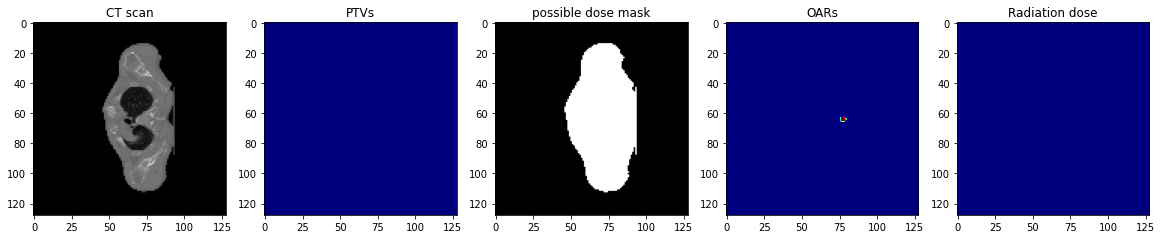

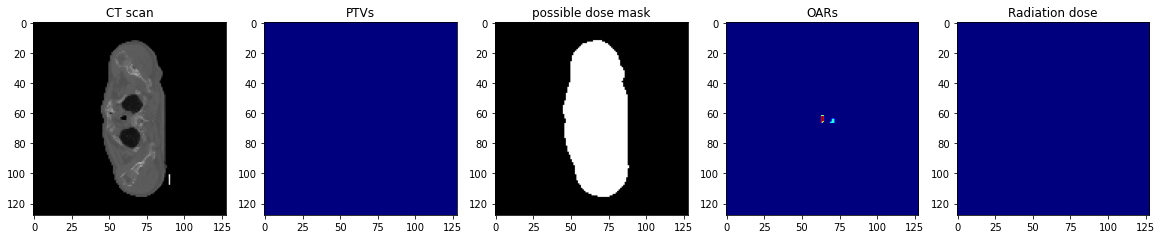

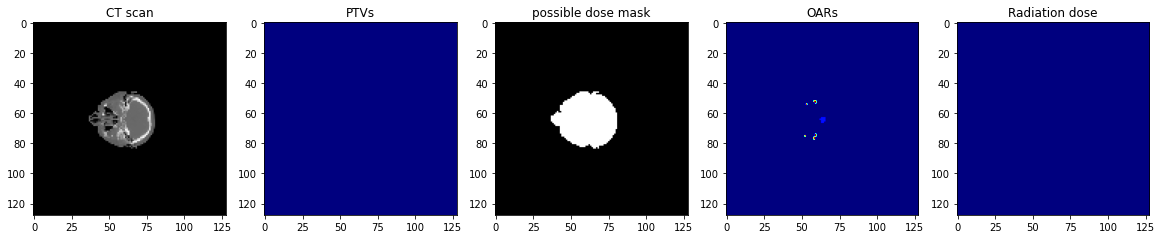

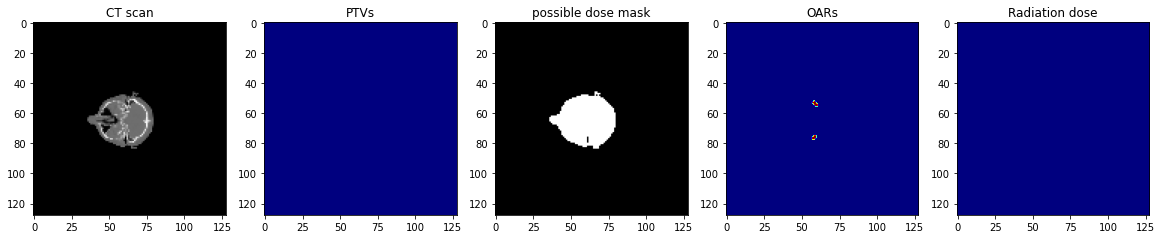

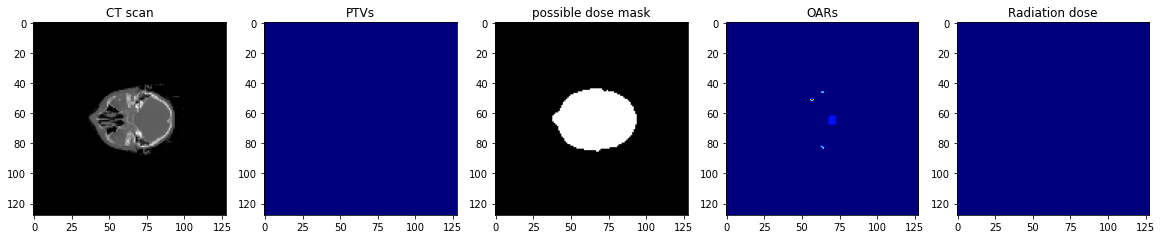

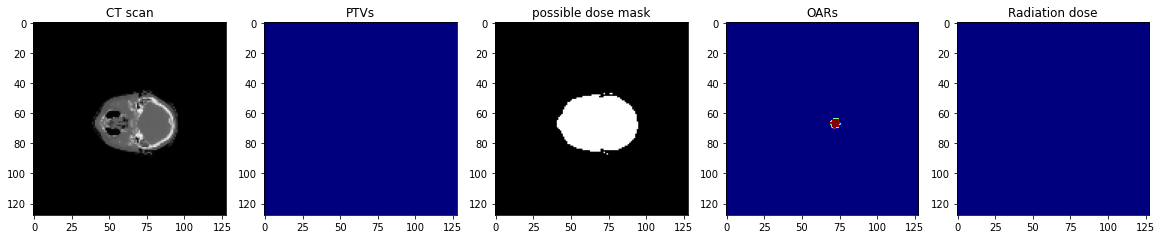

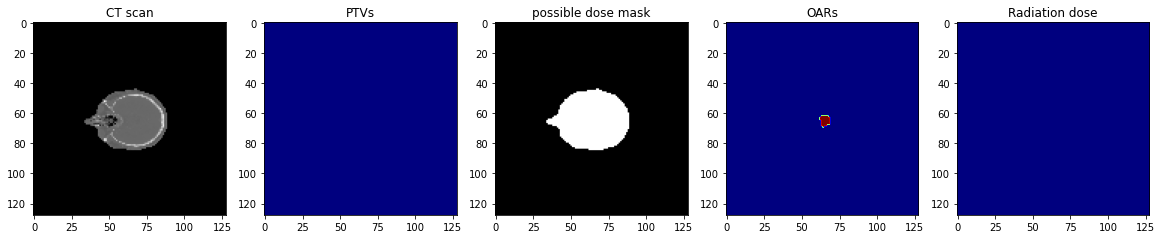

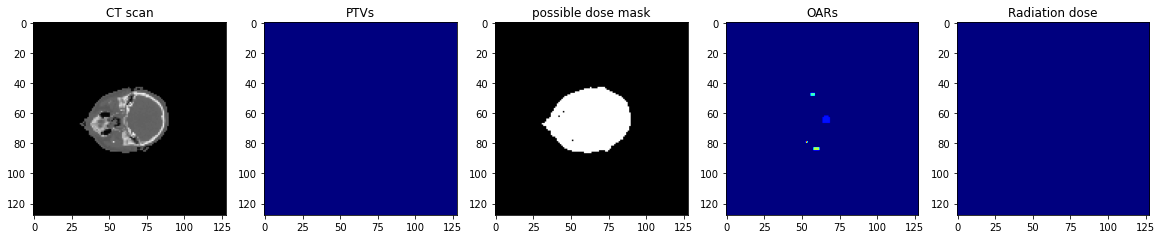

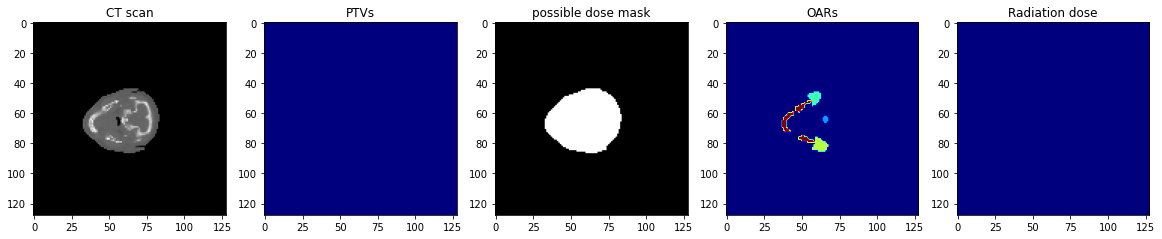

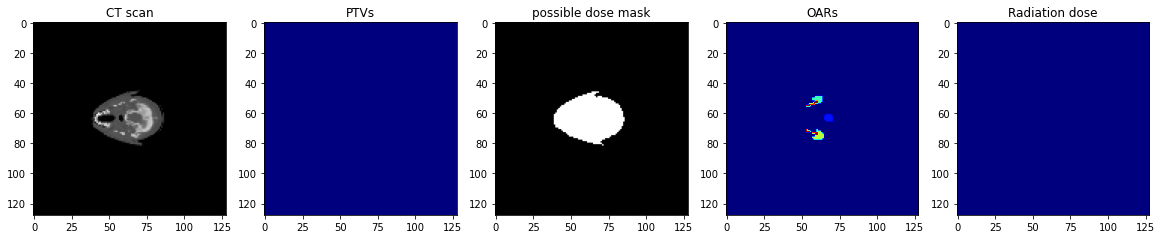

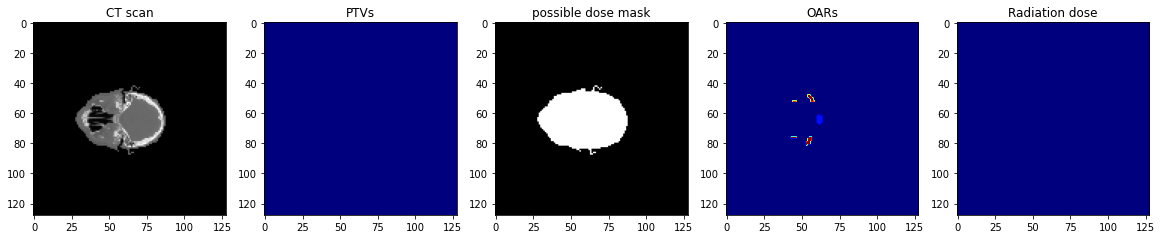

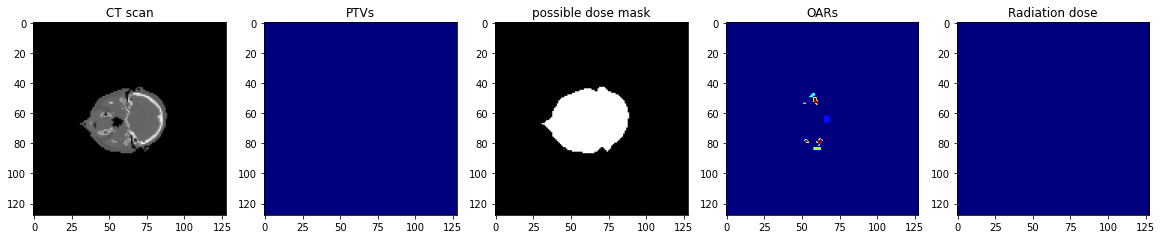

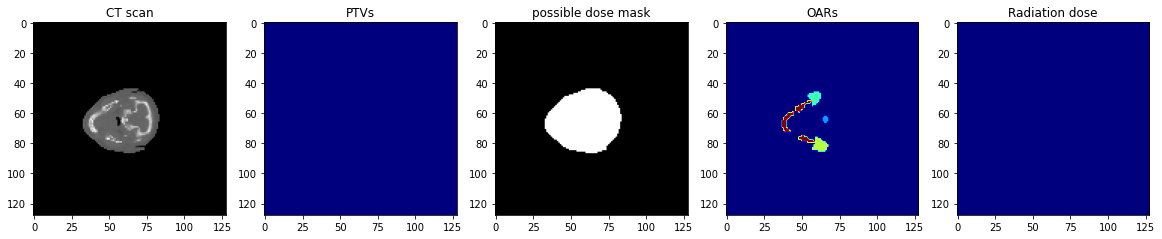

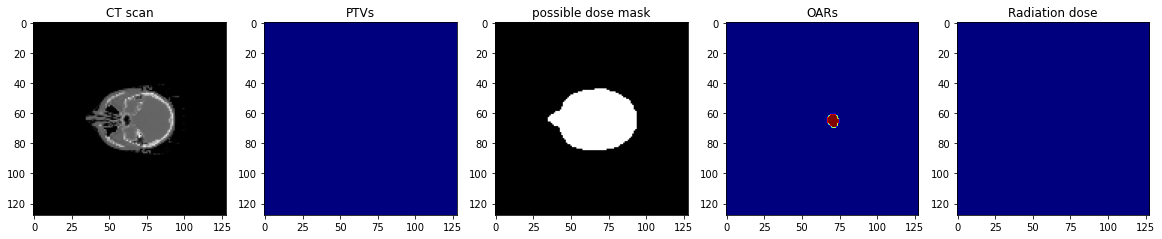

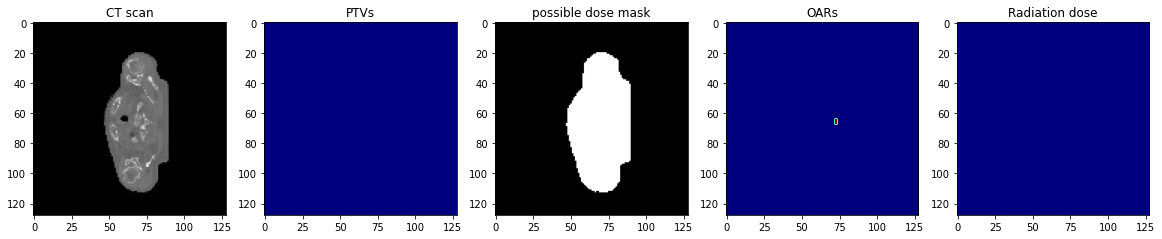

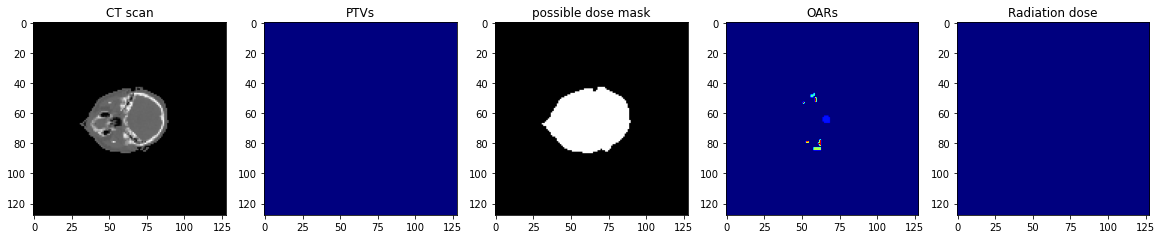

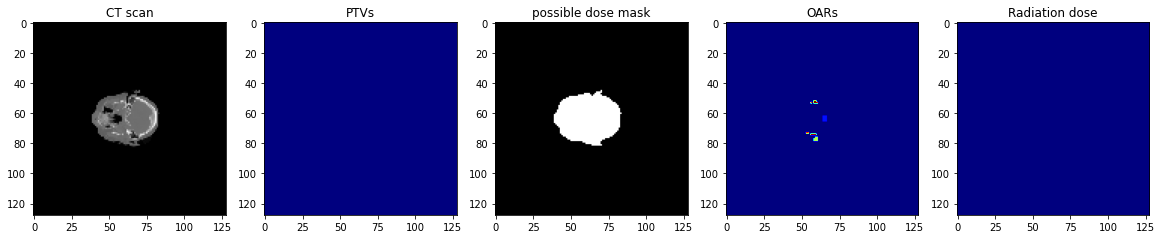

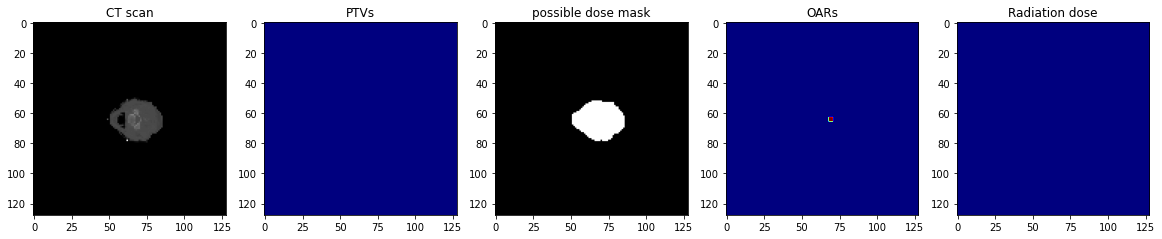

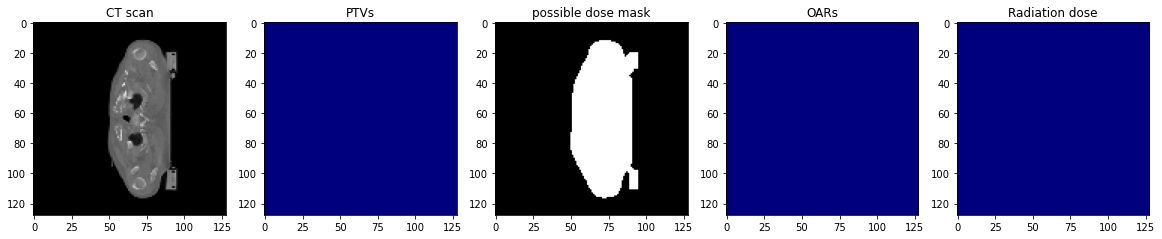

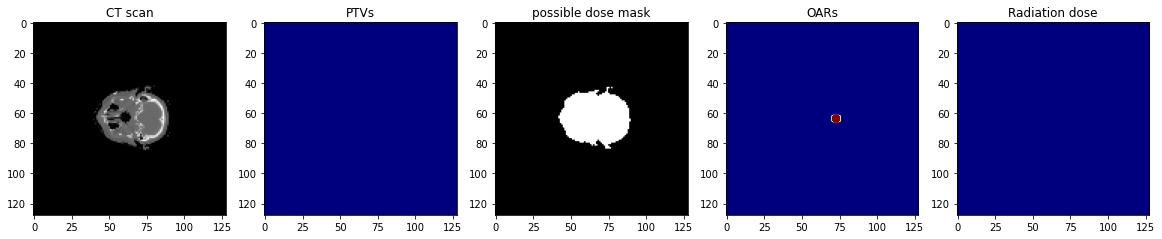

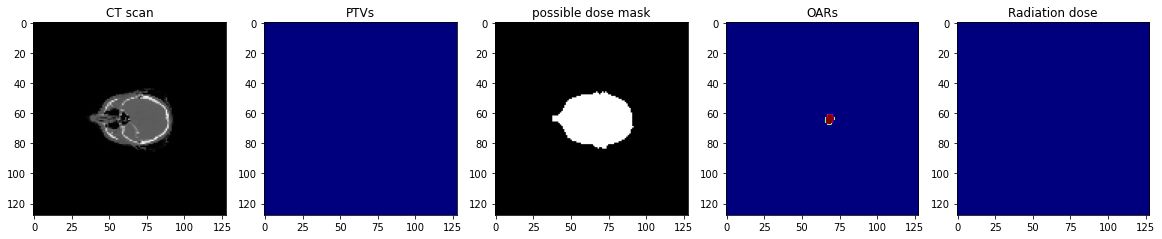

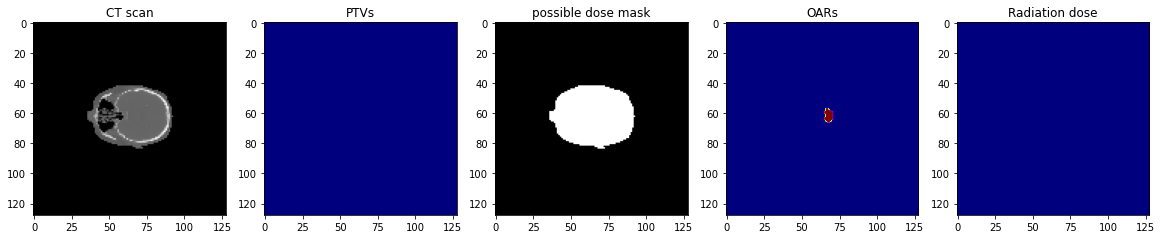

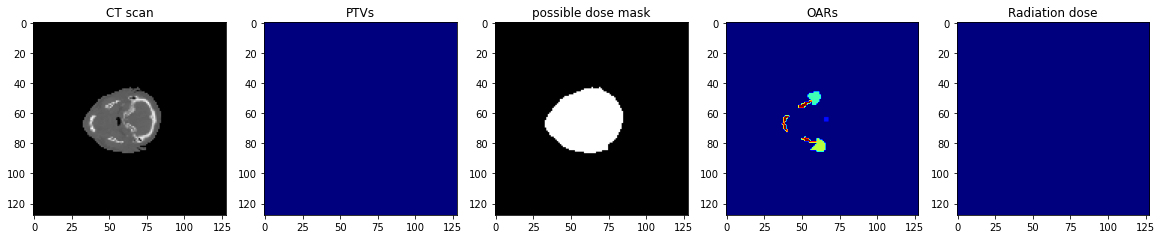

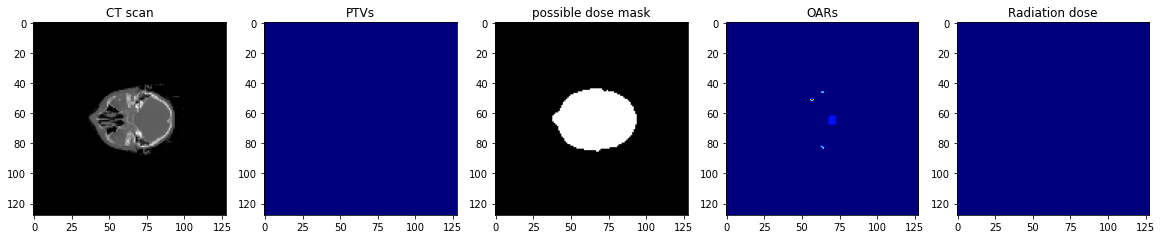

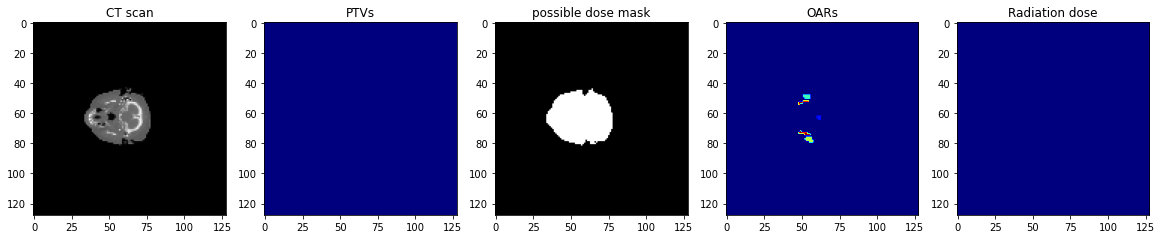

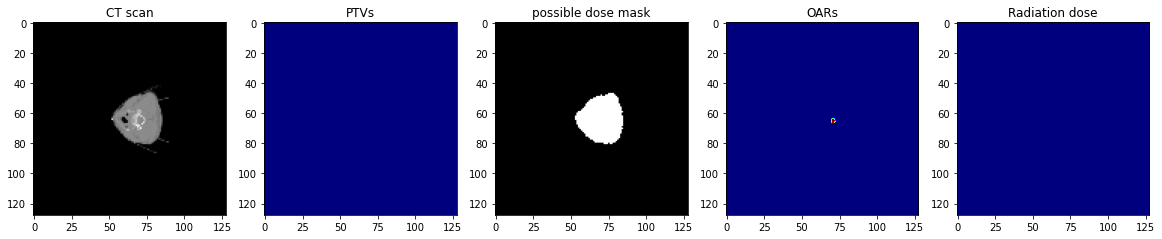

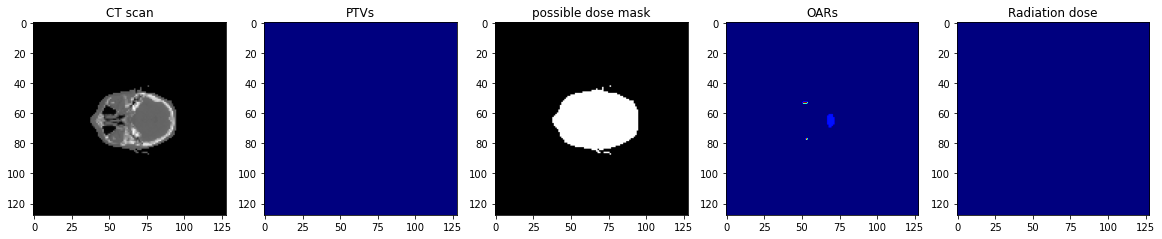

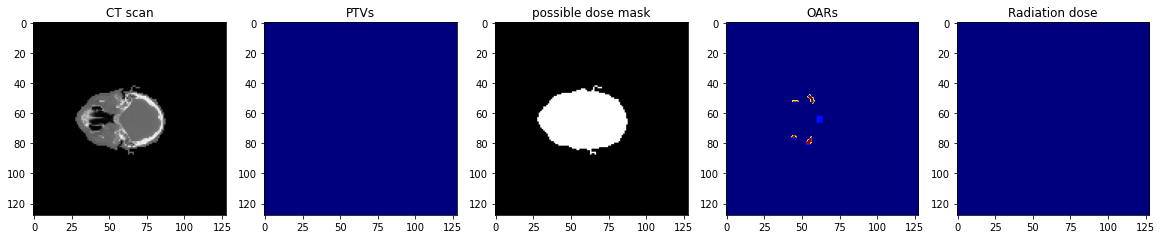

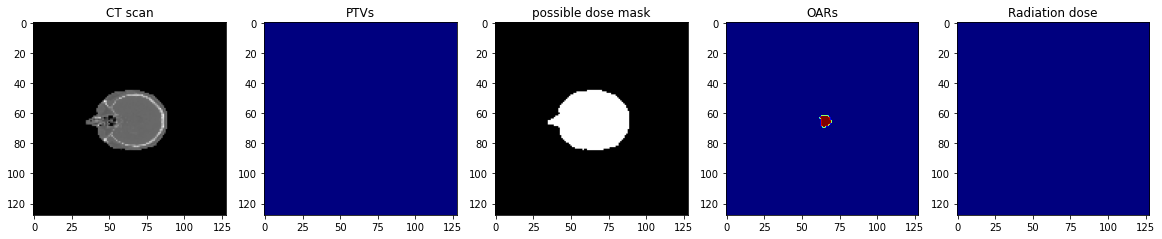

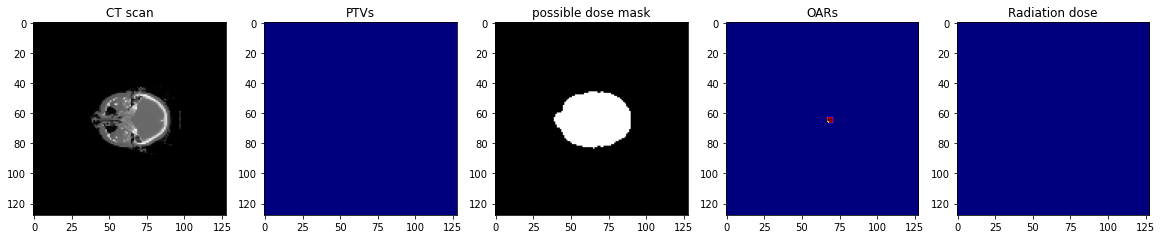

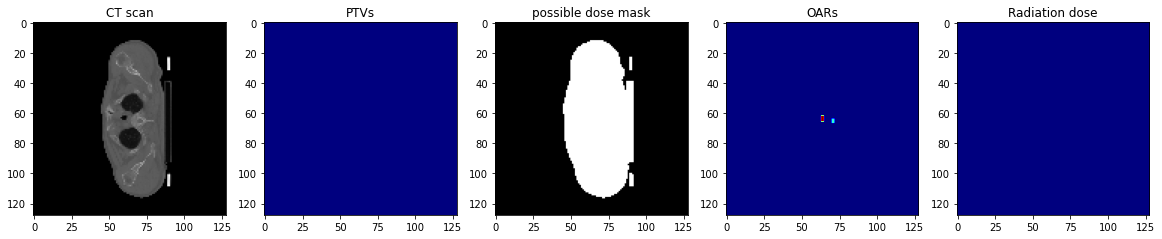

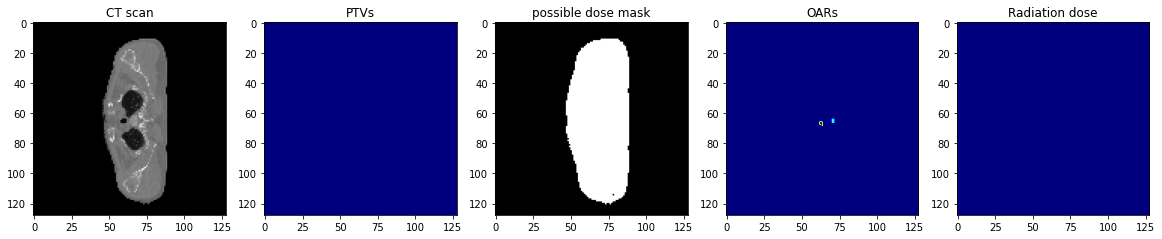

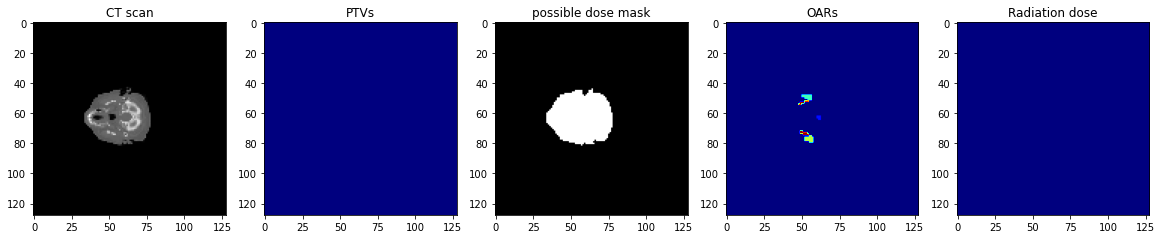

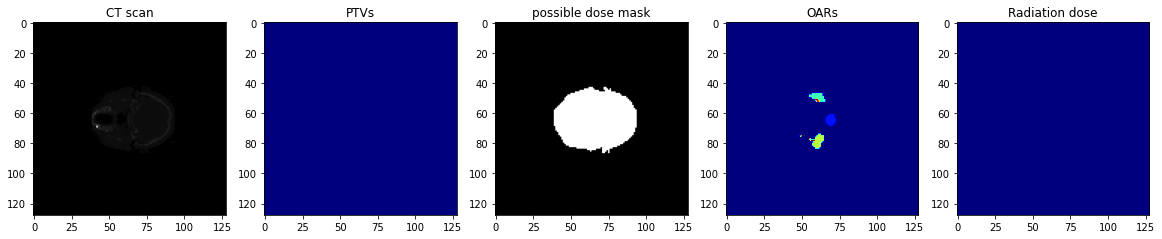

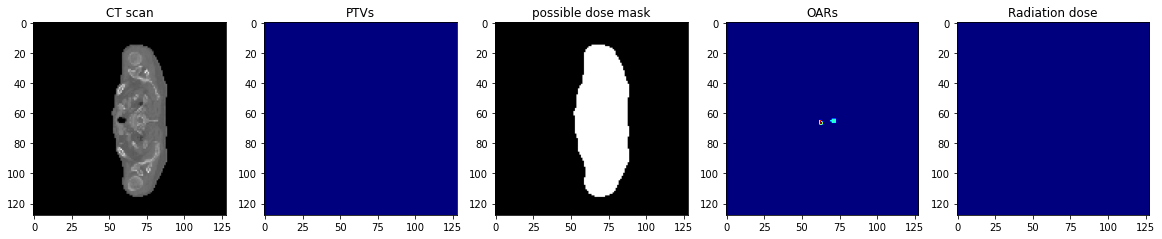

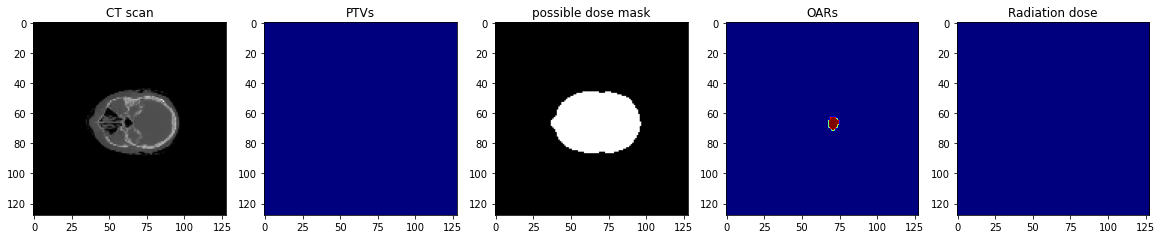

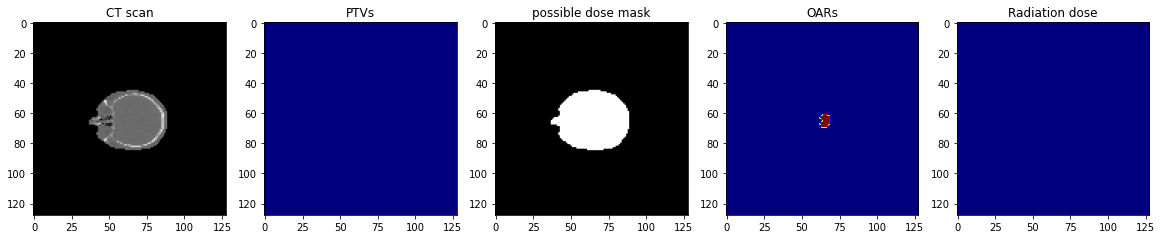

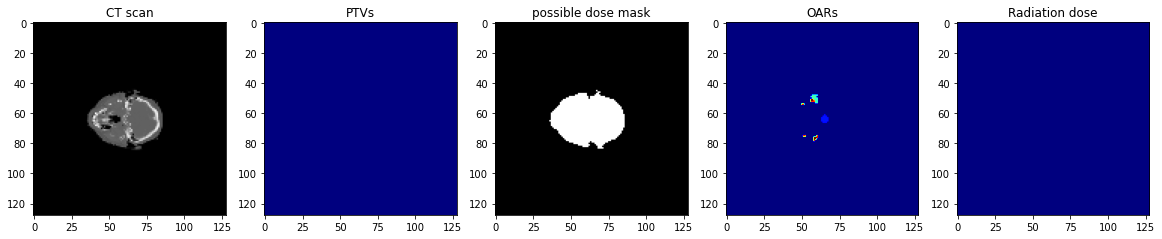

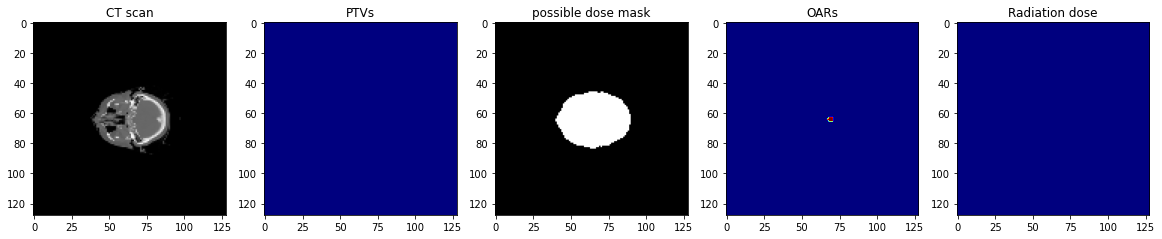

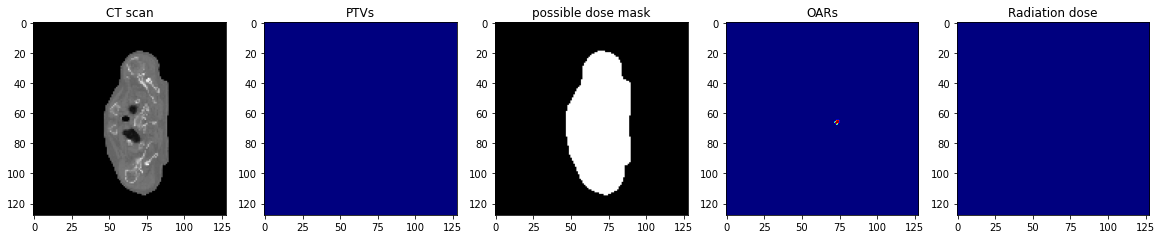

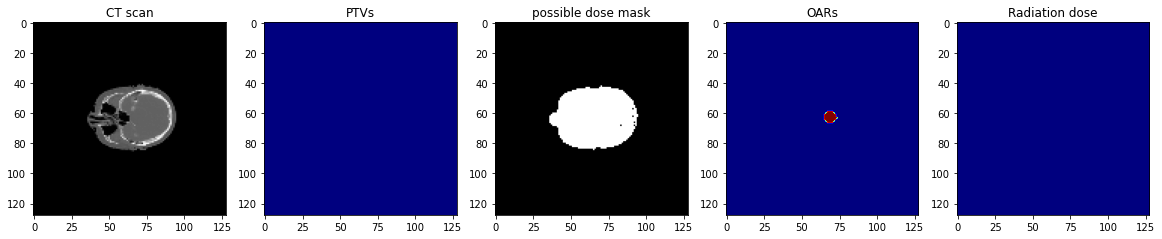

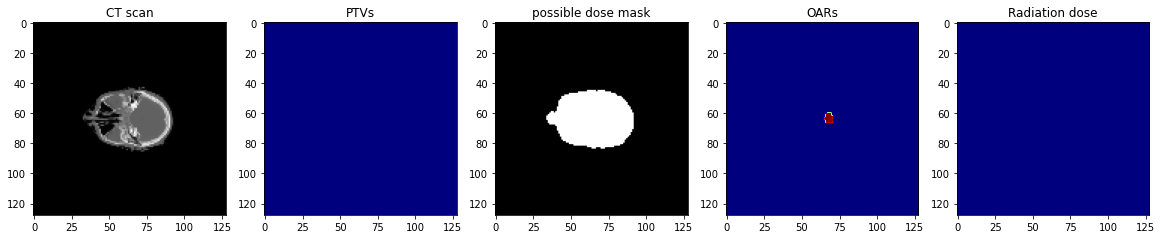

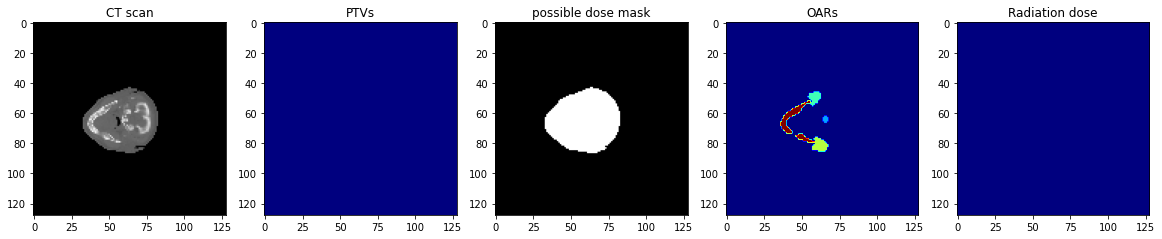

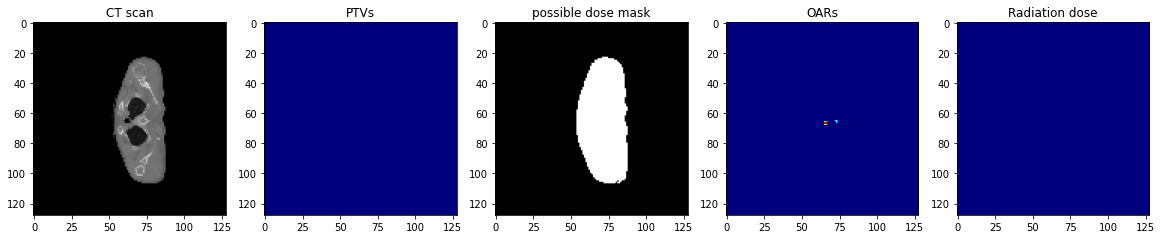

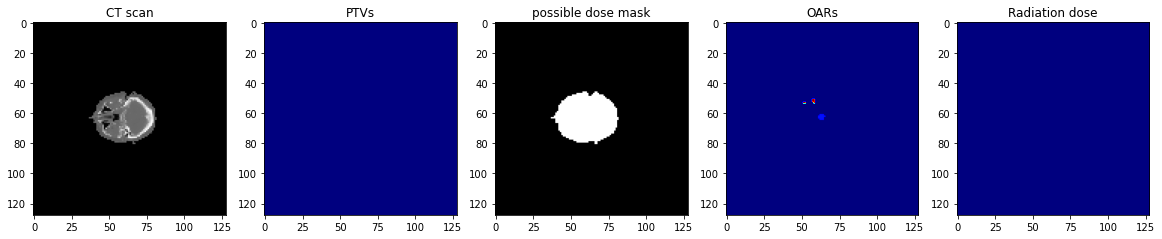

In [6]:
for p in missing_indices:
    if 'test' not in p:
        continue
    dict = read_data(p)
    CT_scan = dict[2]
    PTVs = dict[0]
    OARs = dict[1]
    Rdose = dict[-1]
    mask = dict[3]>0
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("possible dose mask")
    axs[0, 2].imshow(mask, cmap='gray')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs[0], cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')
    plt.show()
    

In [32]:
def custom_distance(a,b):
    mask = np.logical_or(a>0,b>0)
    return np.mean(np.abs(a[mask] - b[mask]))

In [33]:
data_paths = get_data_paths(dir)
CTs = read_CT_scans(data_paths)
missing_indices = missing_PTVs(data_paths, in_test=True)

mask = np.ones(CTs.shape[0], dtype=bool)
mask[missing_indices] = False
missing_CTs = CTs[missing_indices]
non_Missing_CTs = CTs[mask]
pairwise_distance = sklearn.metrics.pairwise_distances(missing_CTs.reshape(missing_CTs.shape[0], -1),
                                                    non_Missing_CTs.reshape(non_Missing_CTs.shape[0], -1),
                                                    metric=custom_distance)
closest_CTs = pairwise_distance.argmin(axis=1)

10200it [00:09, 1055.60it/s]
10200it [00:03, 2989.89it/s]


<AxesSubplot:>

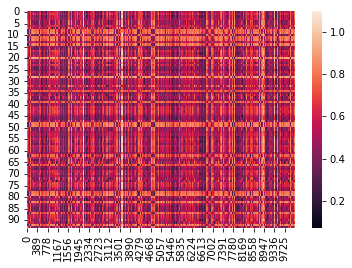

In [34]:
sns.heatmap(pairwise_distance)

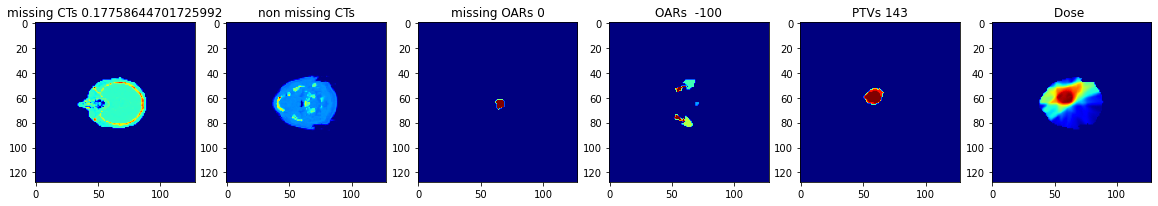

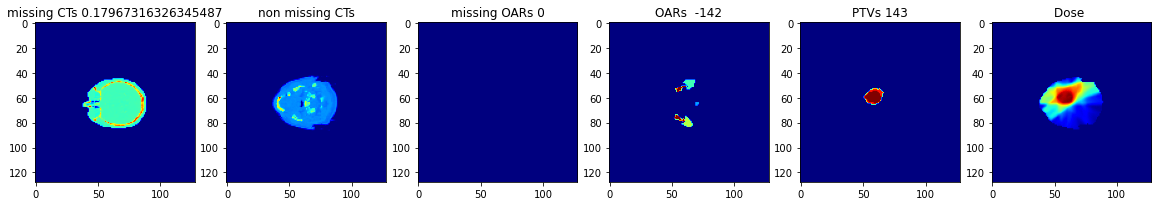

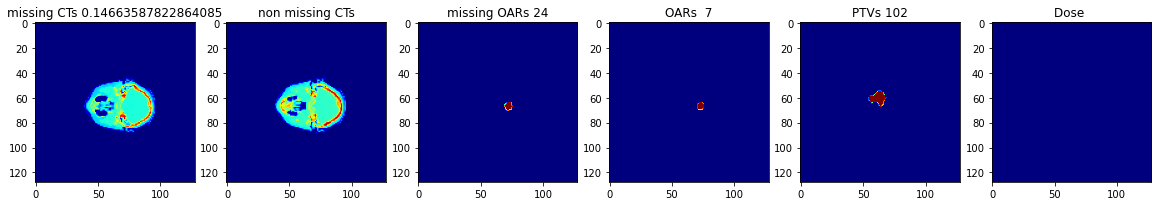

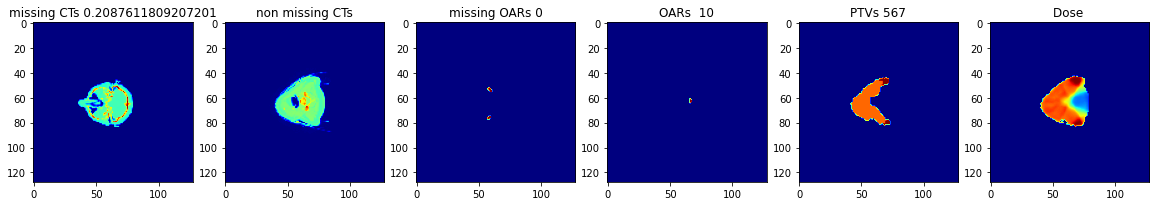

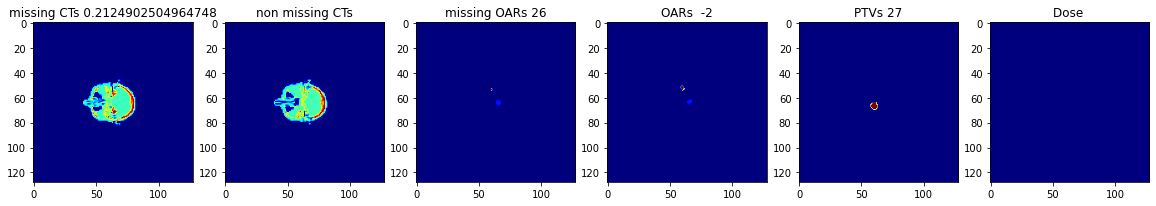

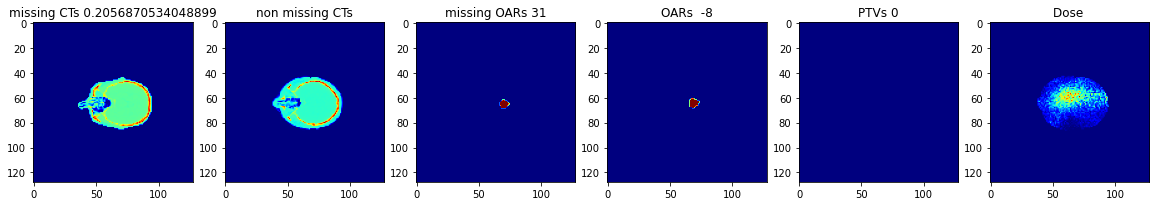

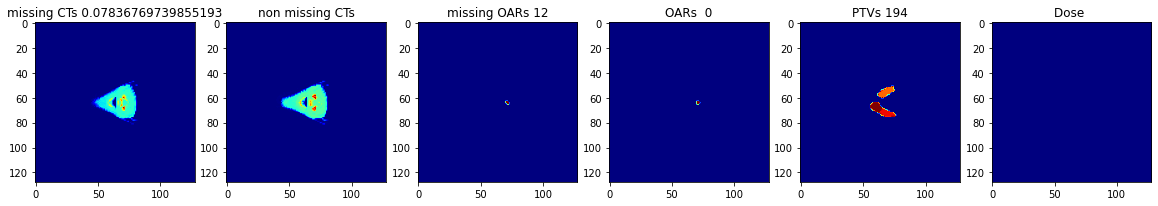

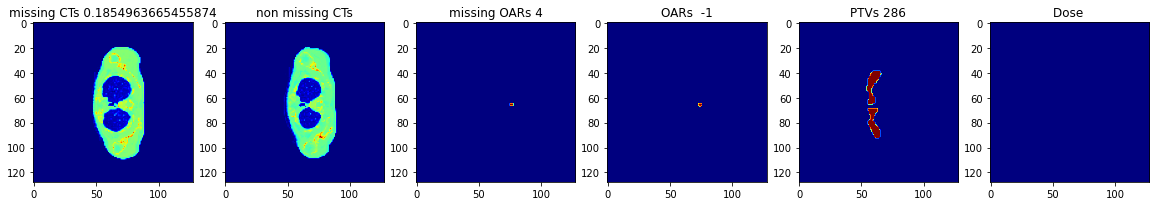

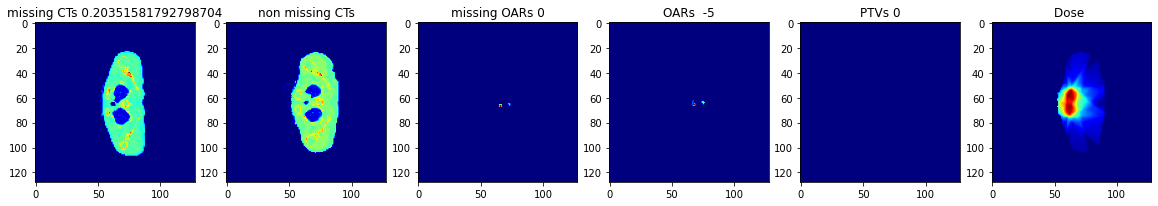

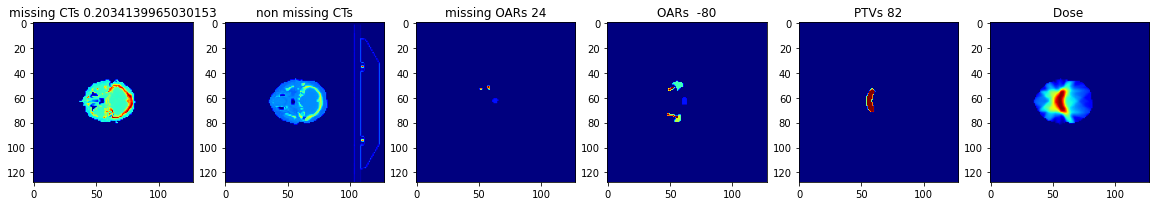

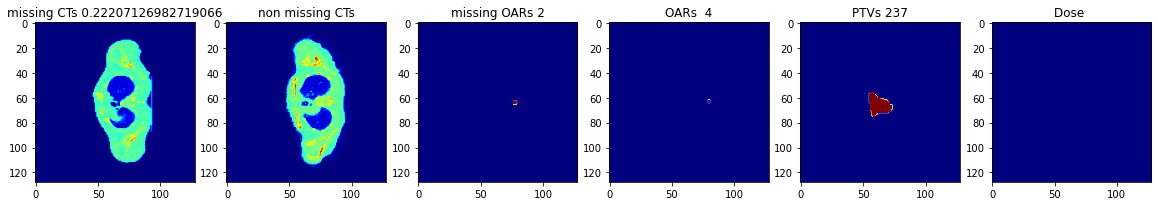

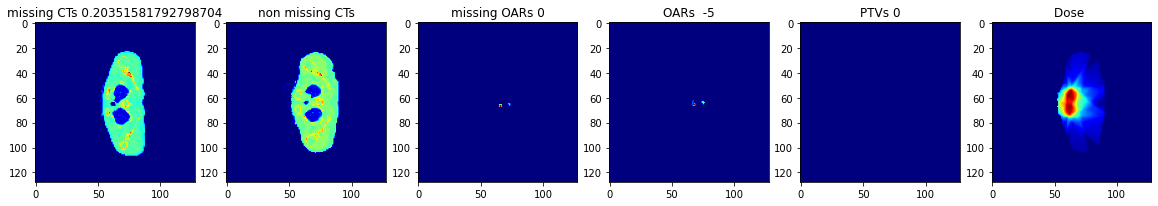

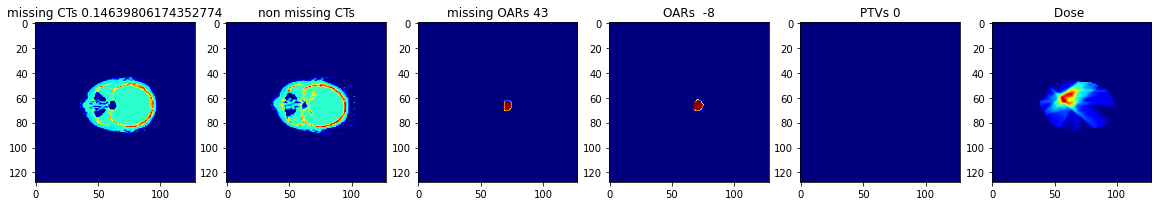

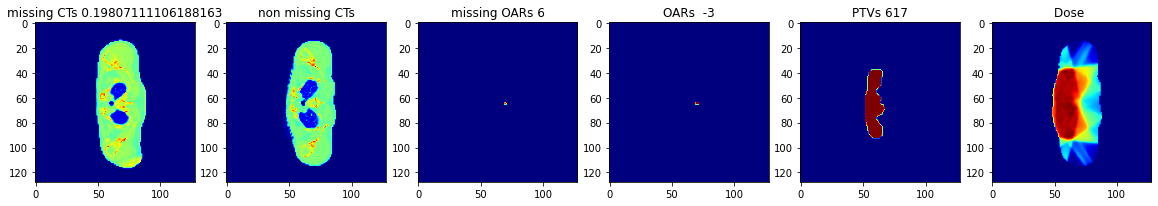

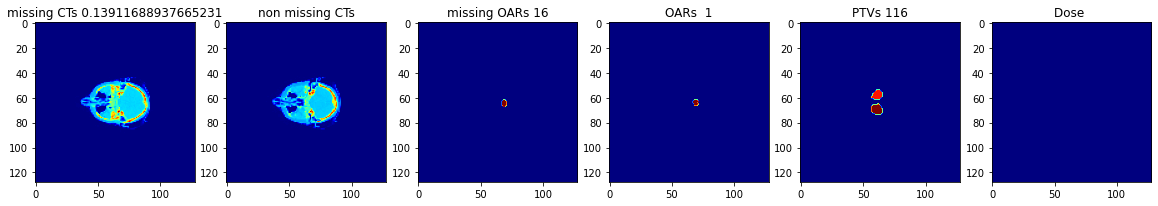

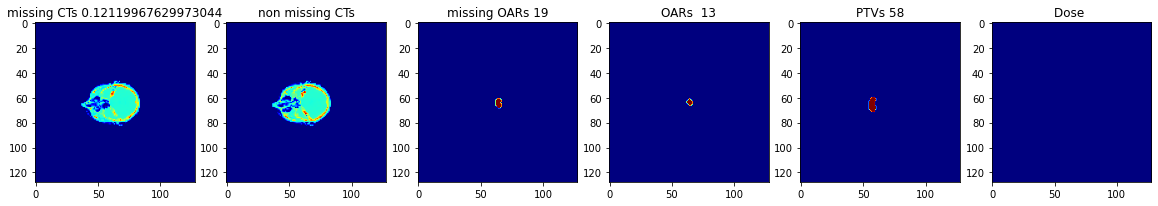

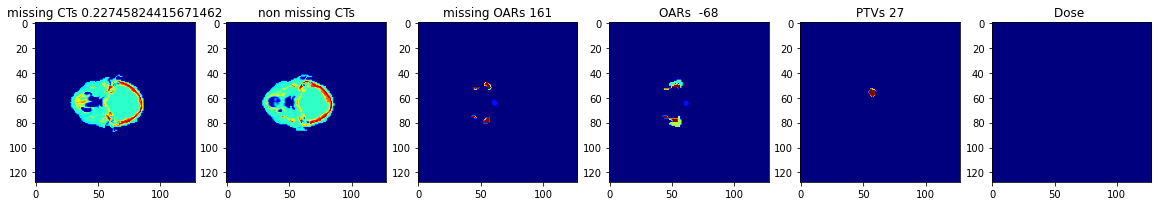

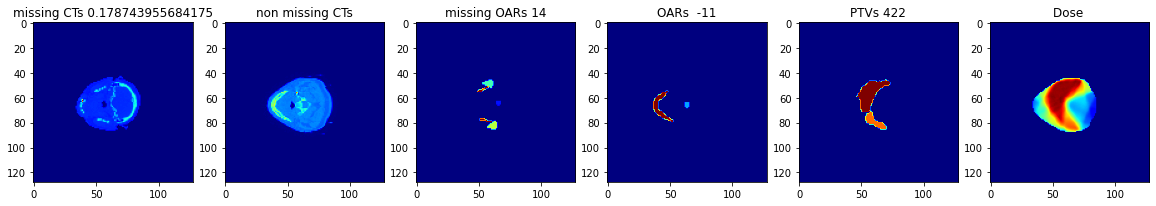

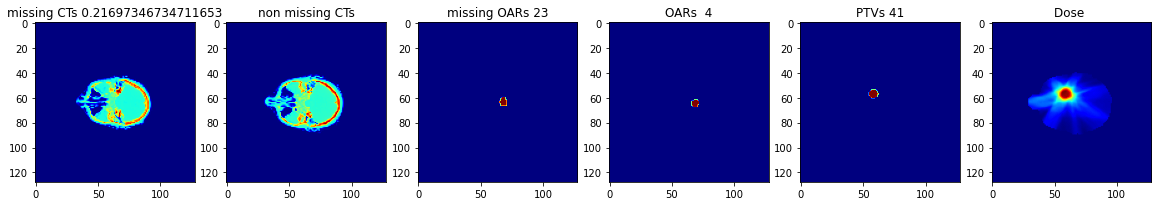

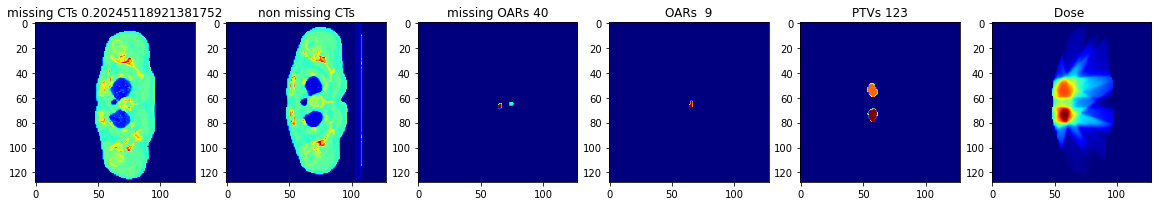

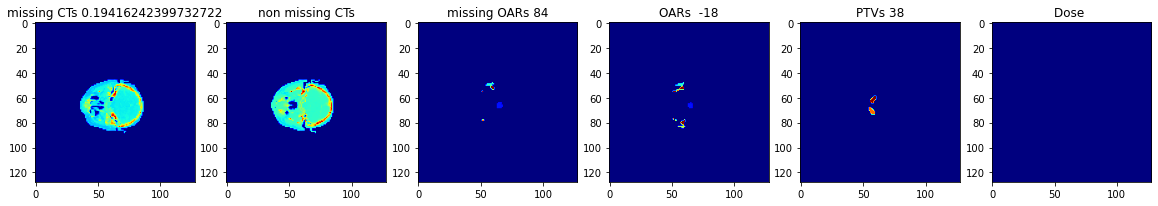

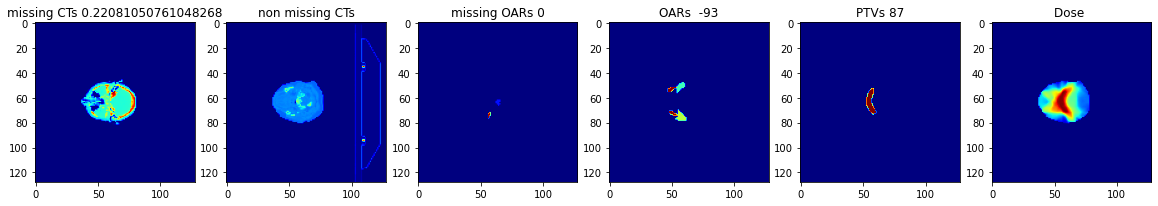

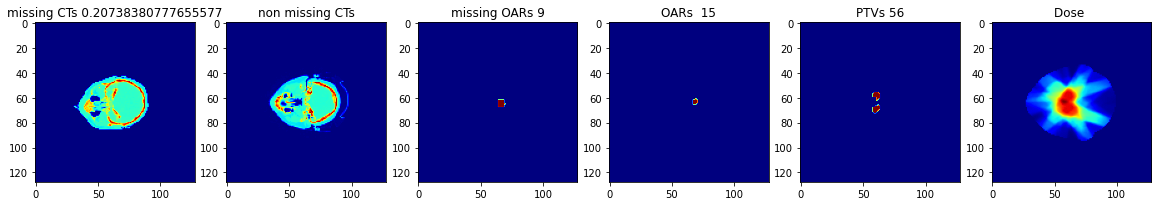

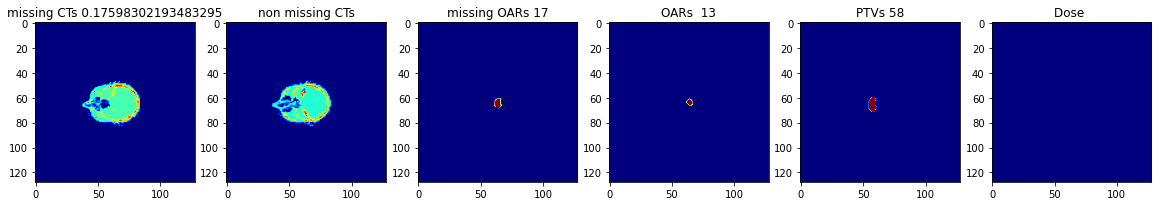

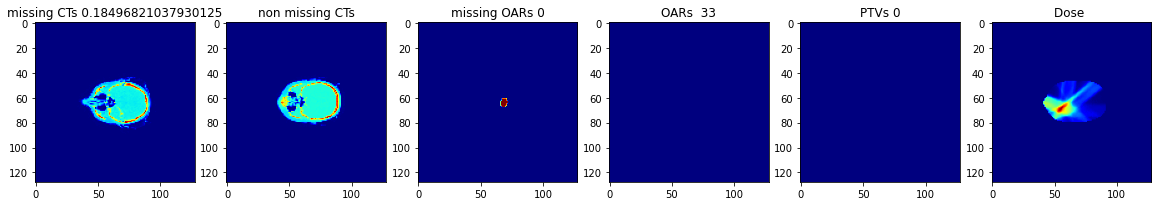

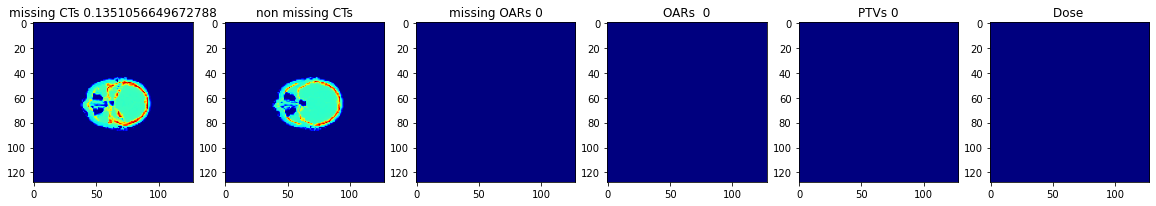

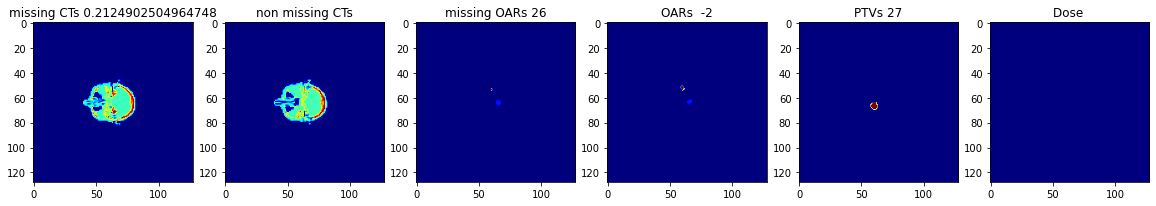

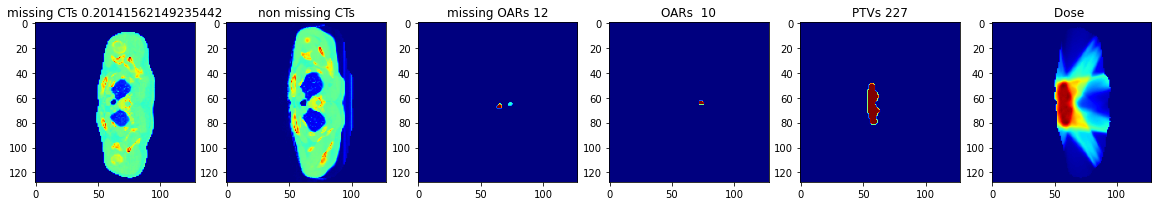

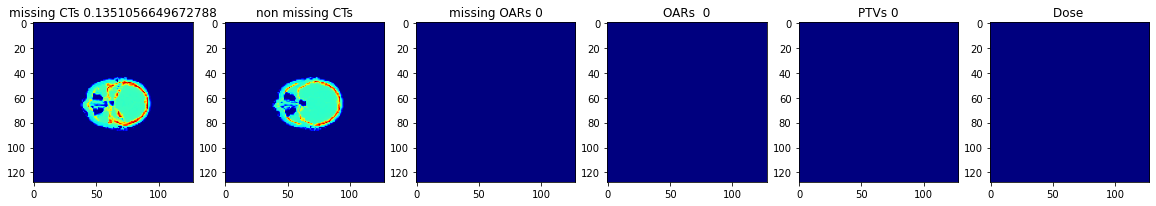

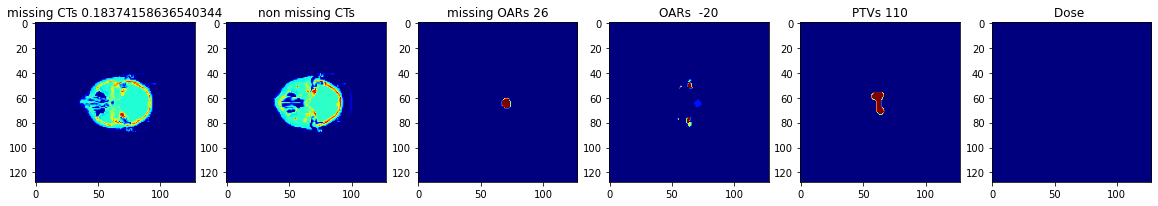

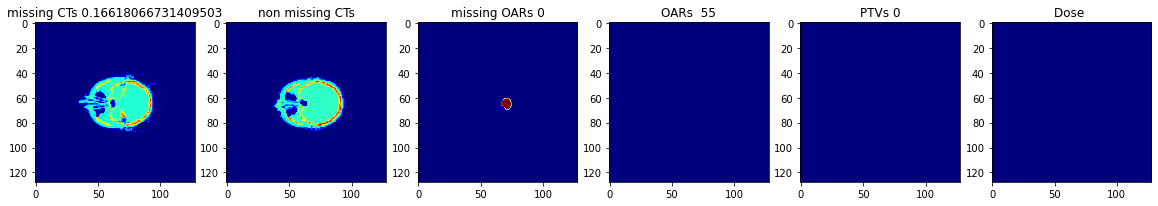

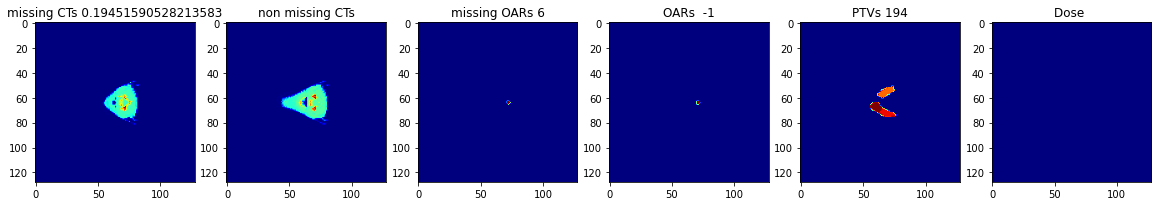

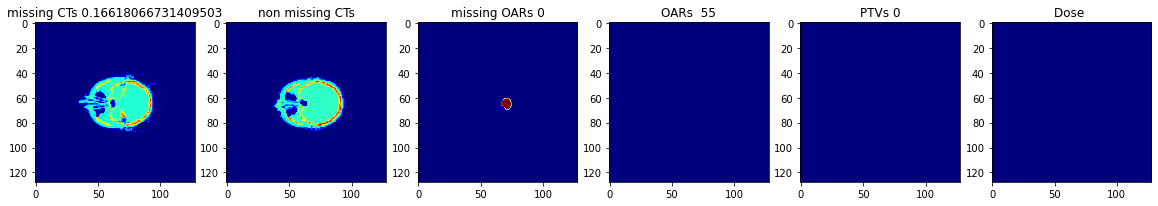

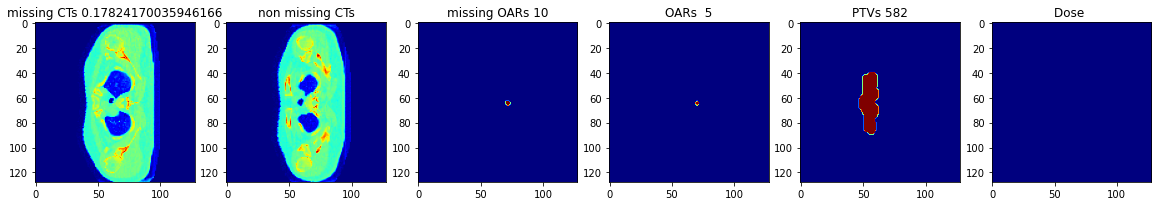

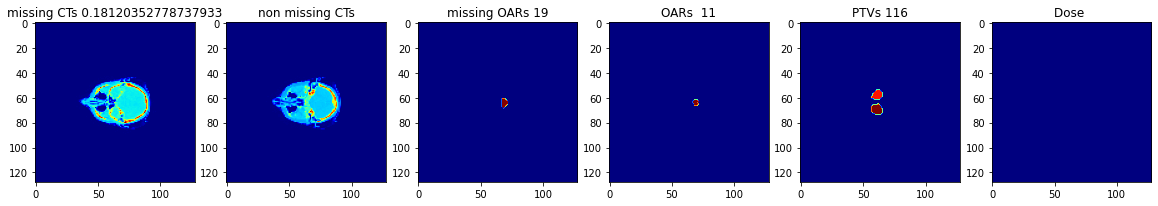

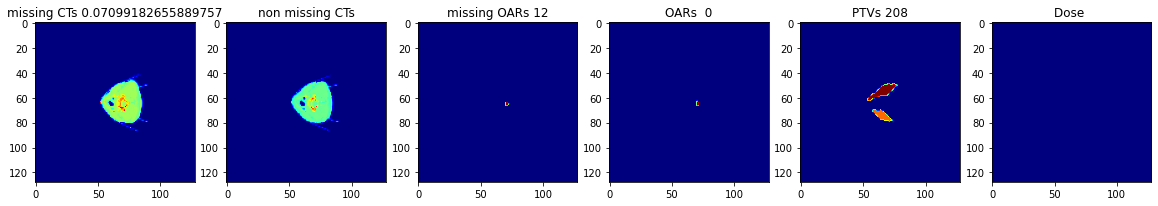

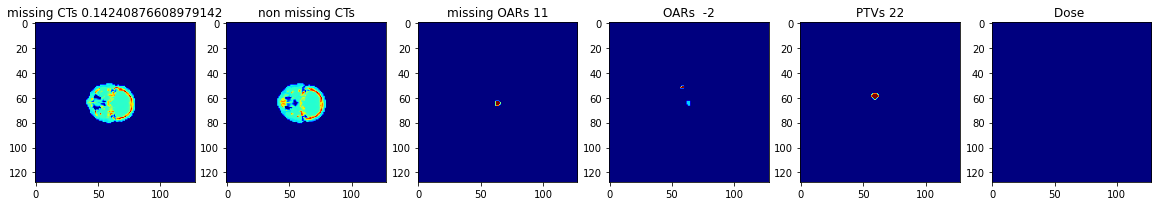

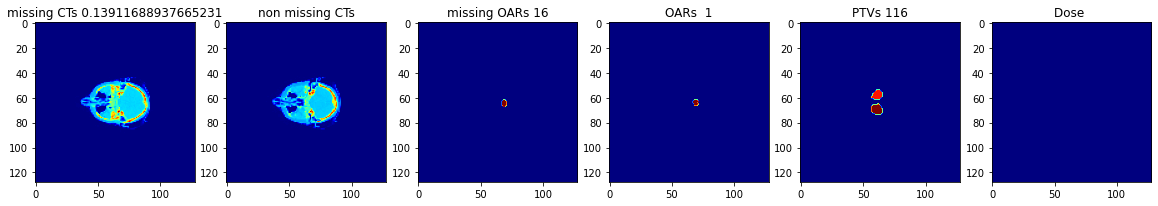

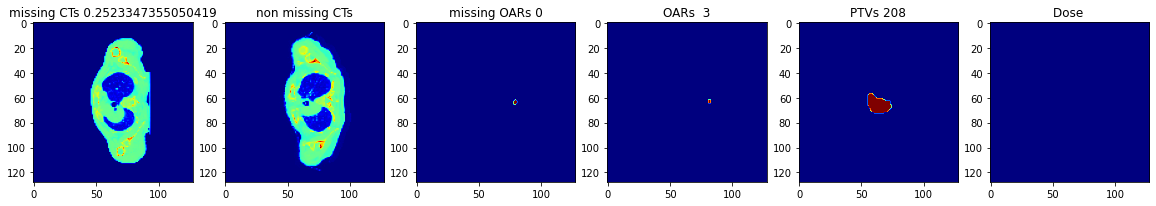

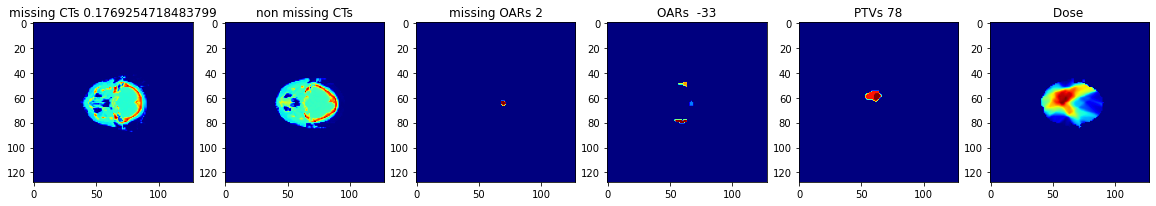

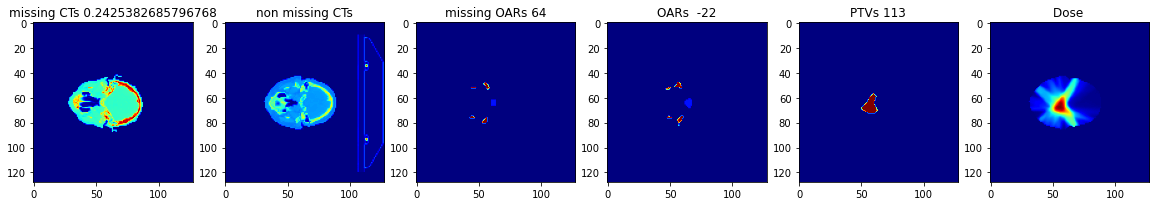

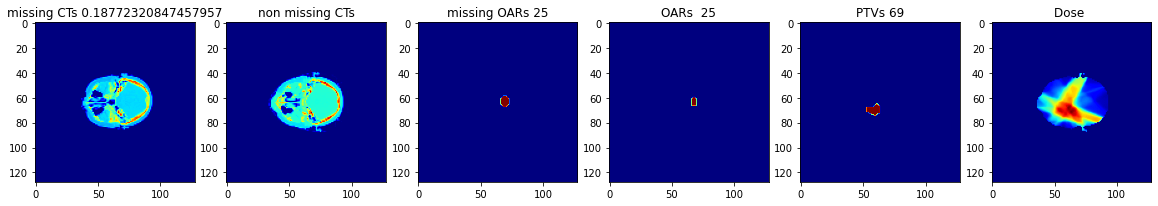

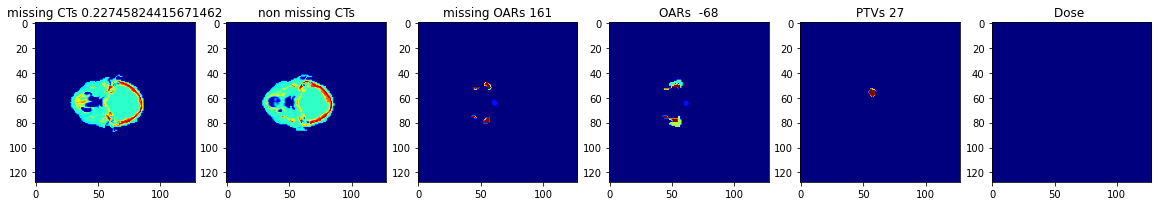

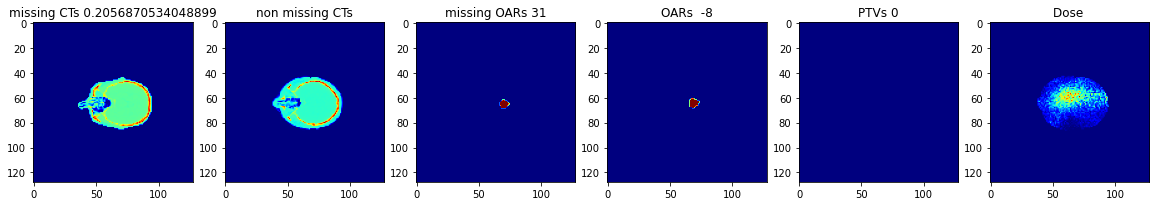

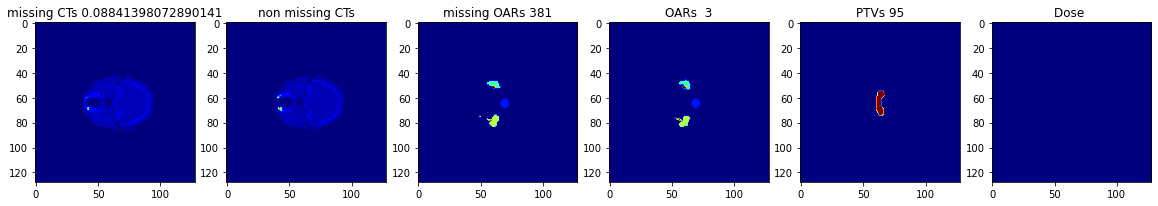

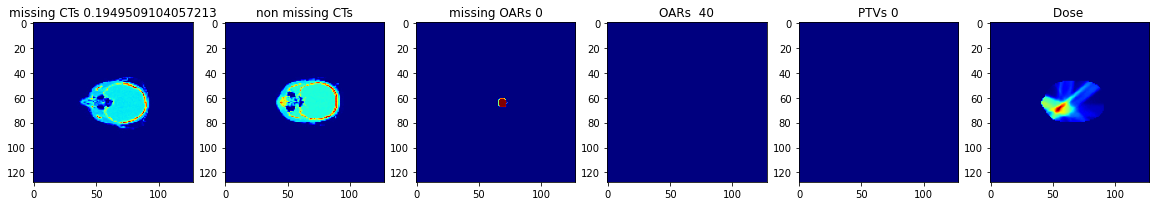

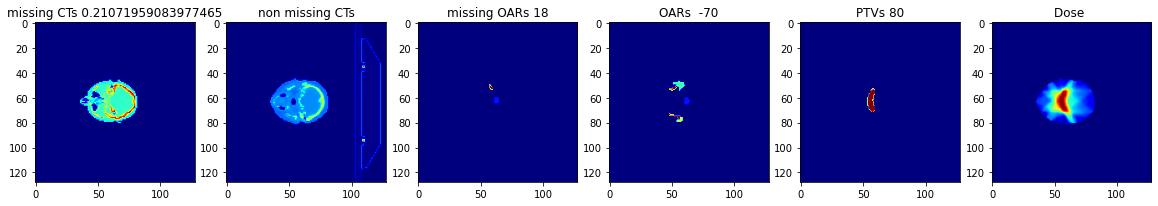

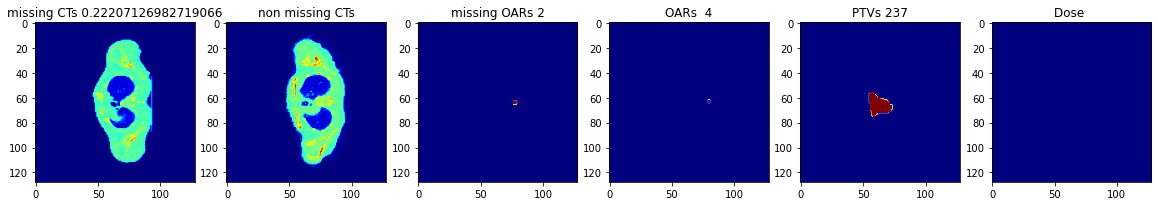

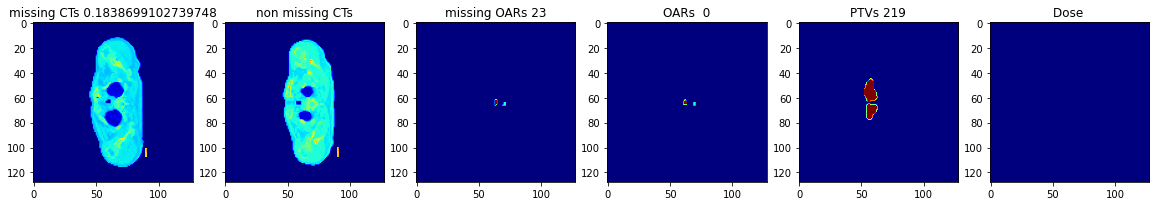

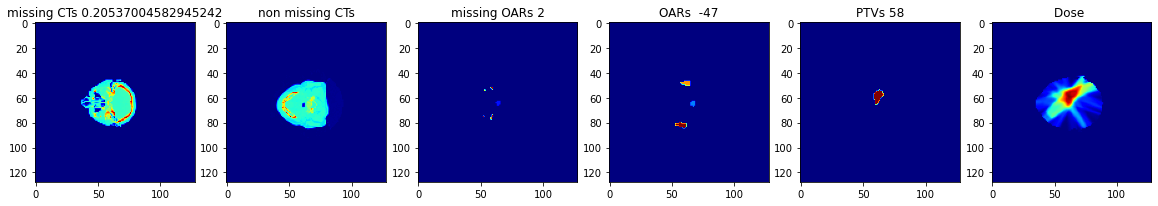

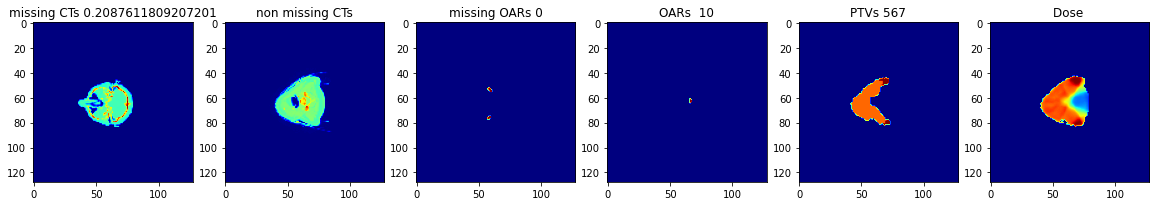

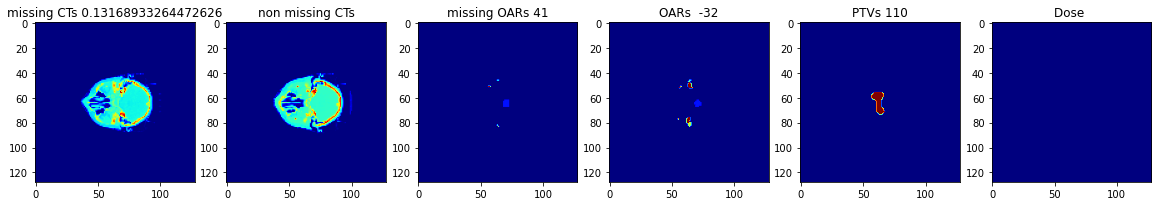

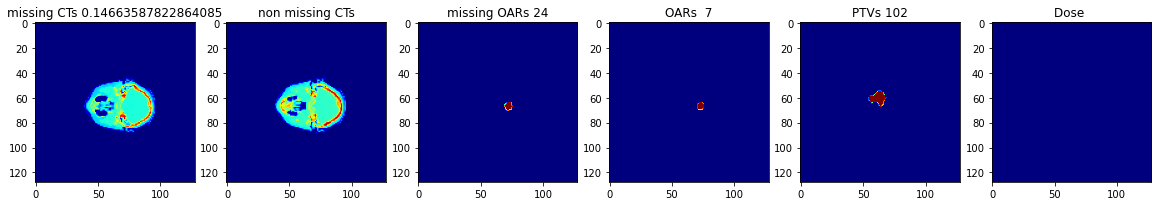

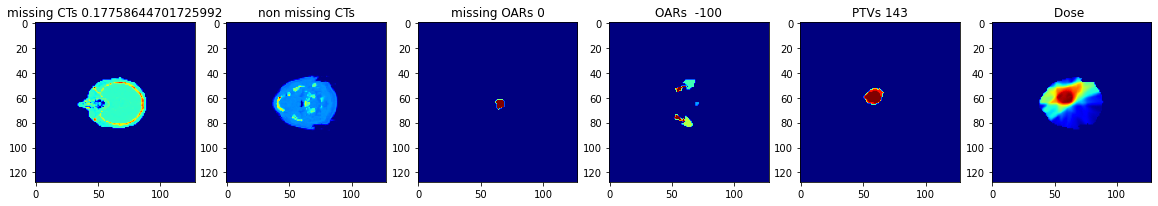

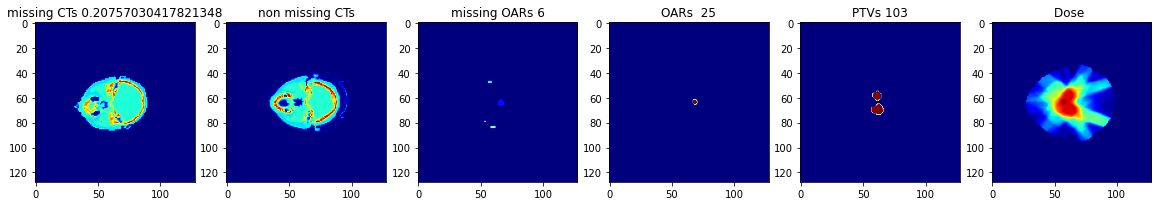

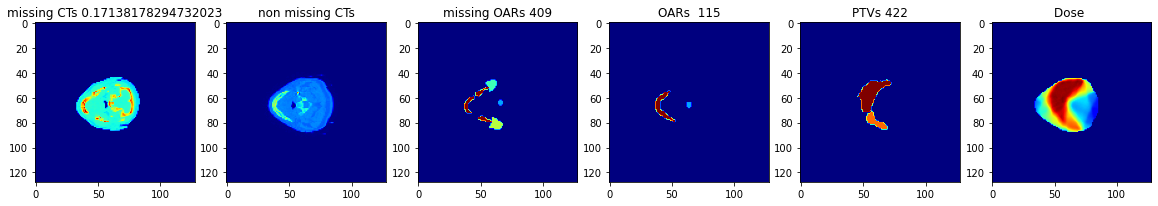

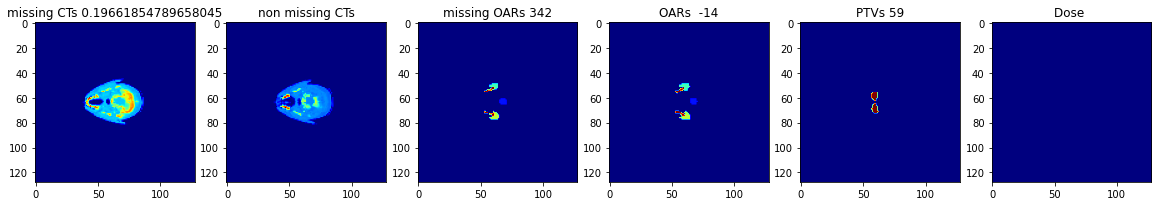

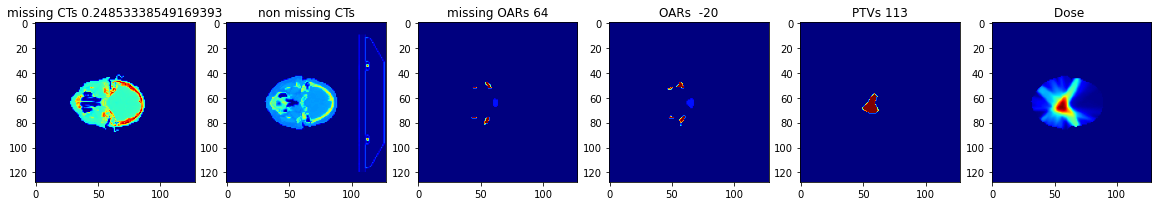

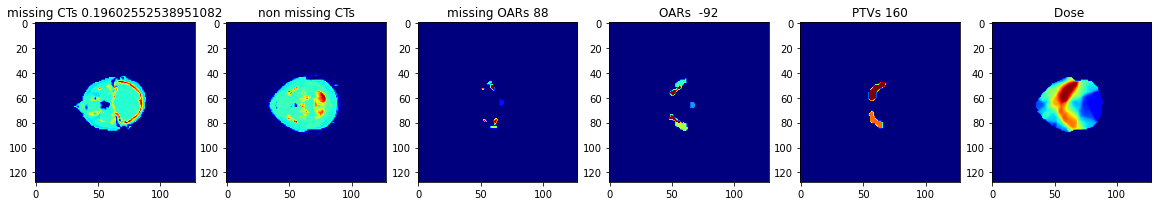

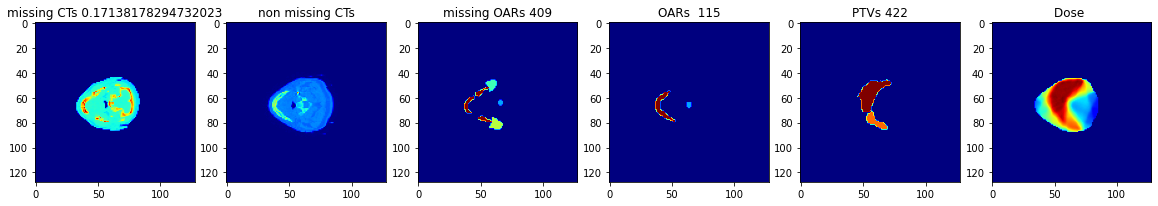

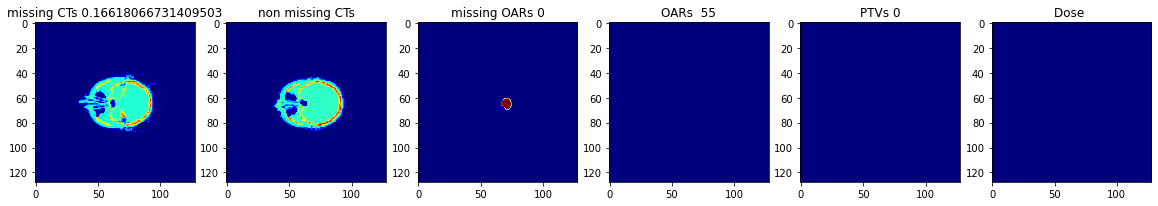

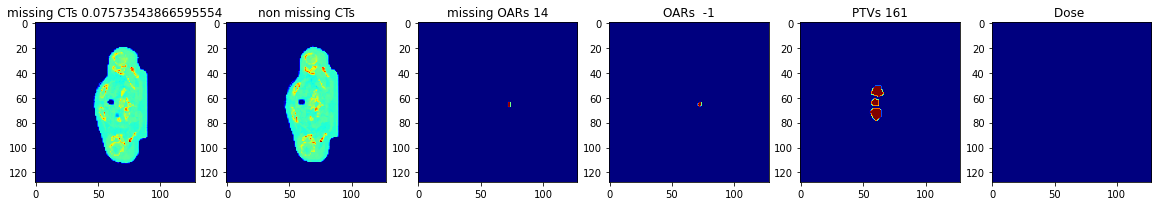

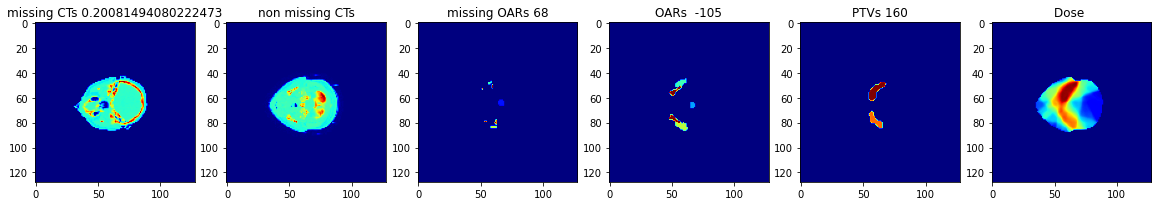

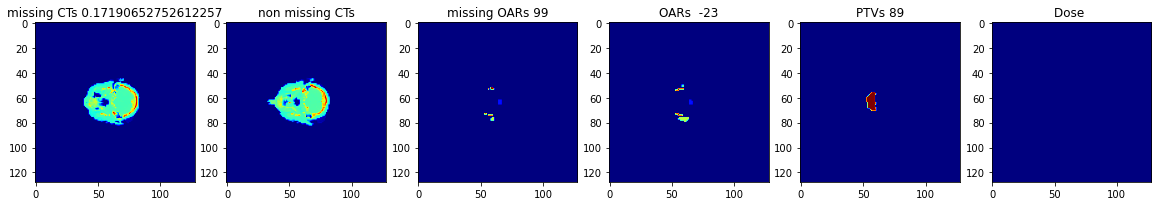

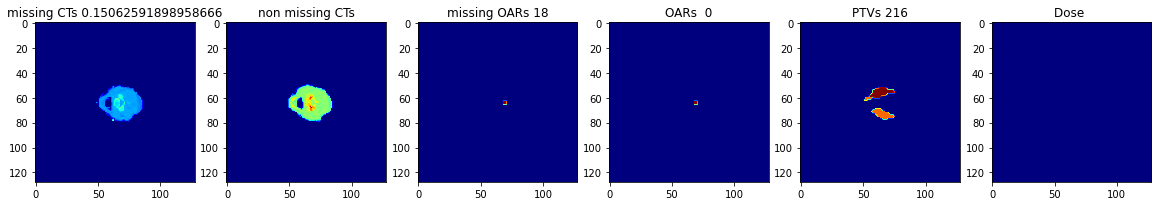

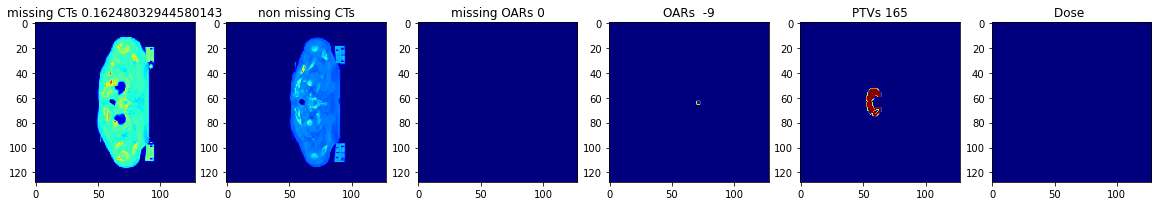

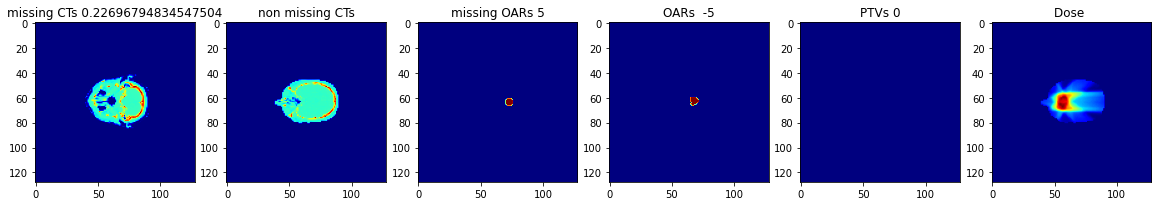

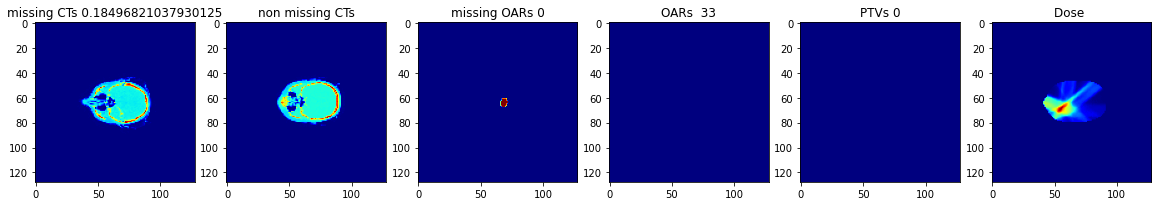

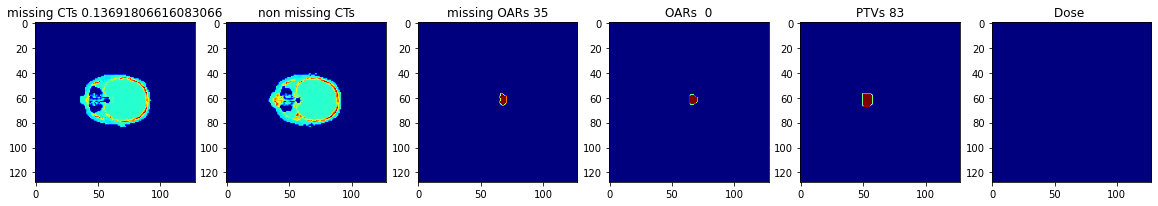

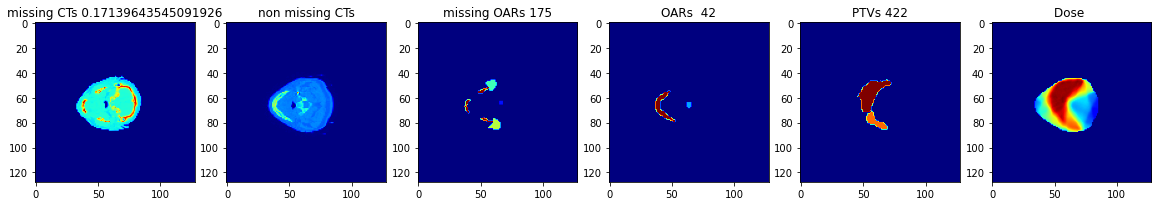

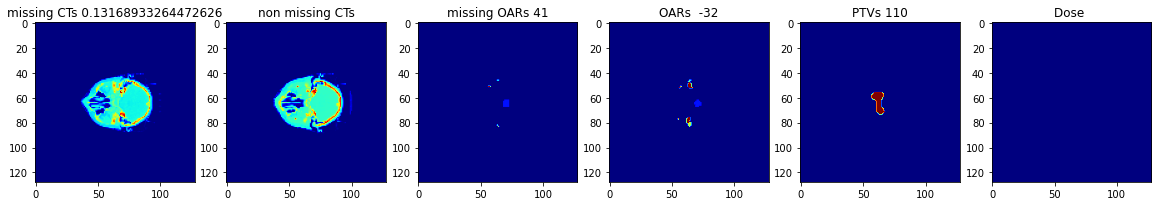

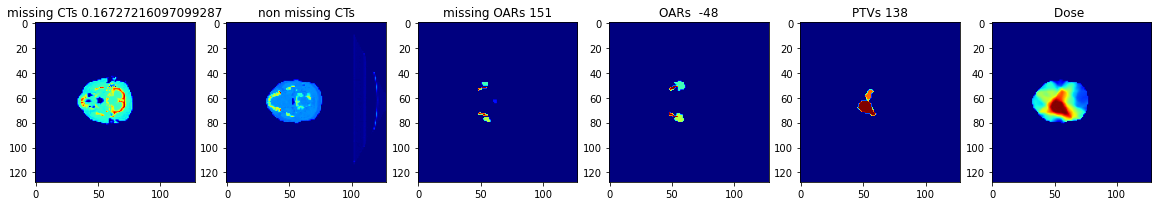

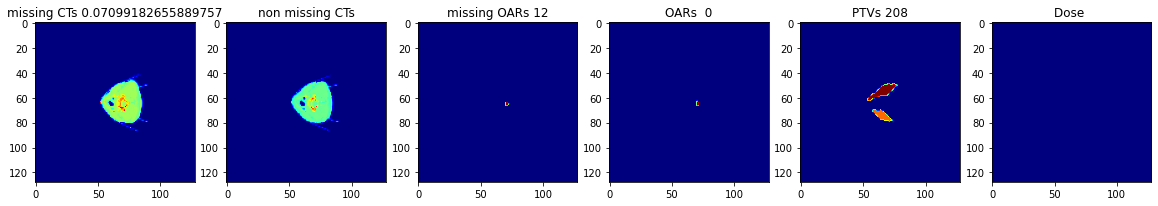

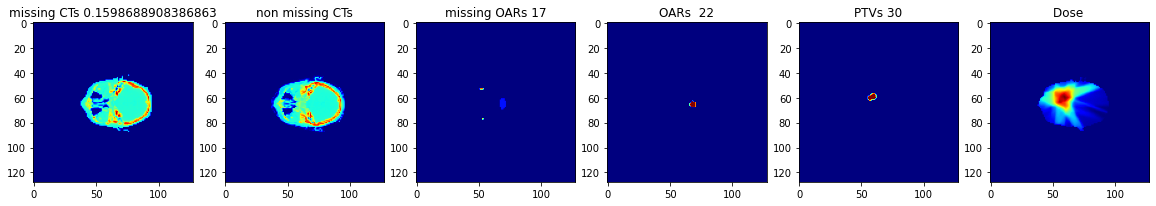

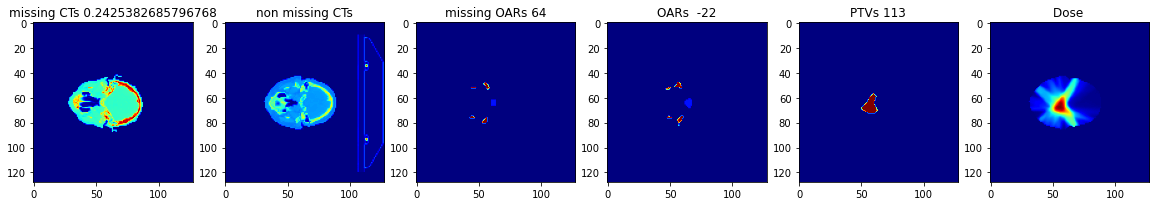

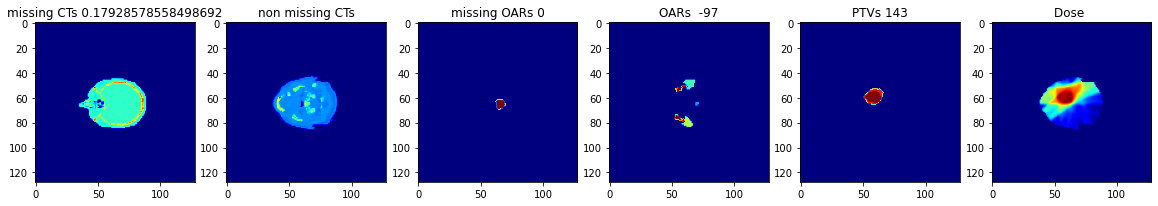

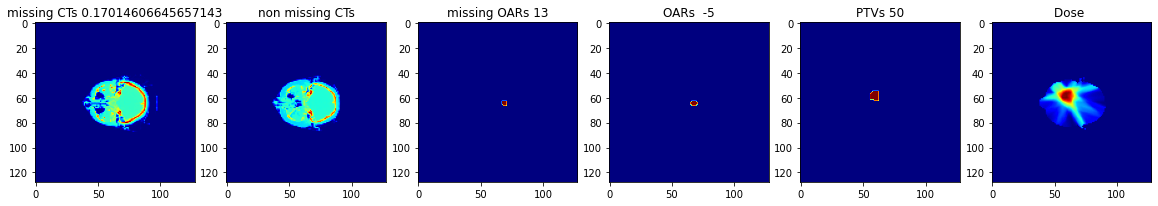

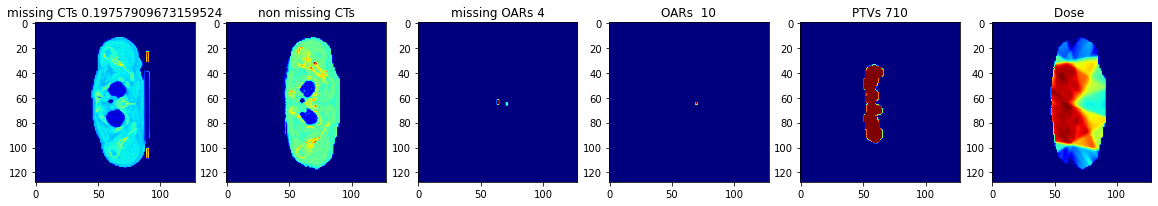

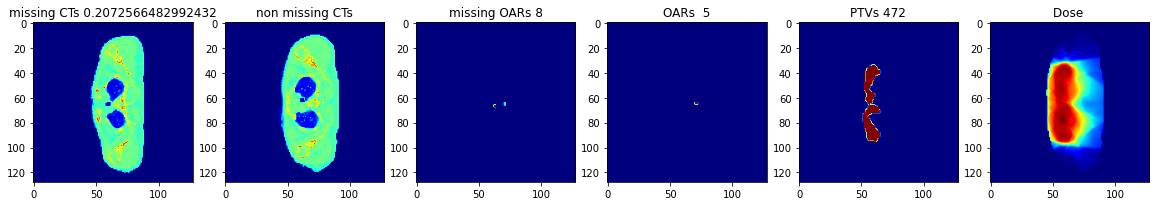

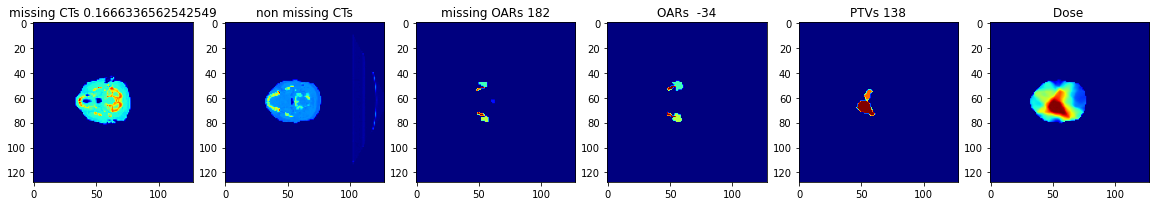

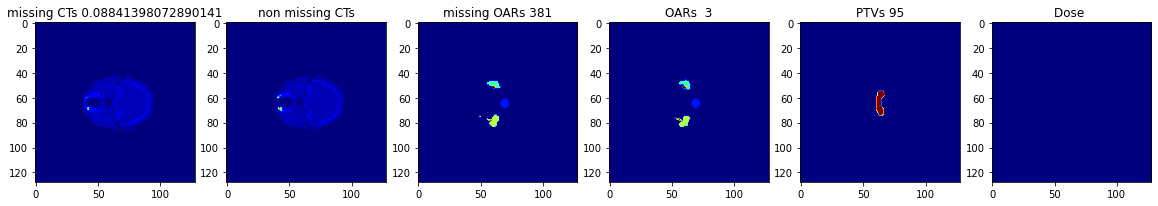

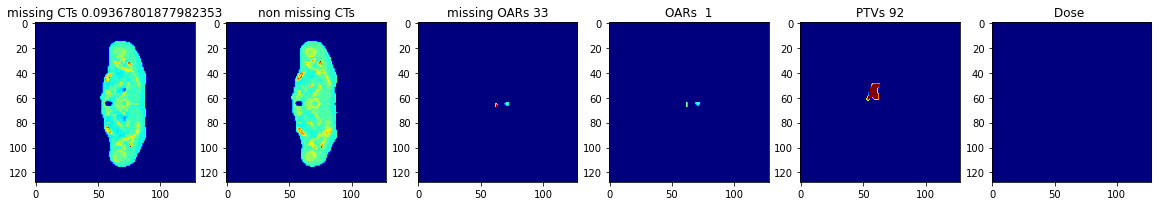

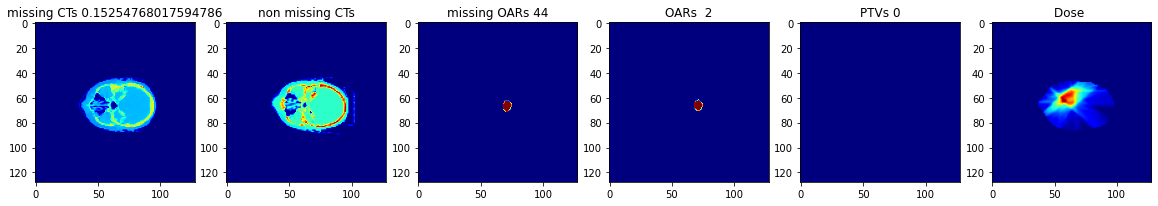

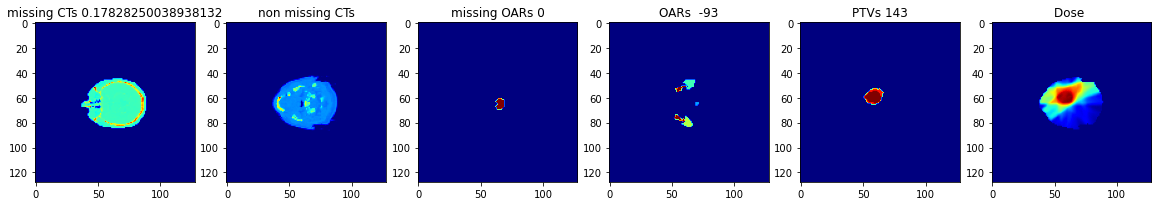

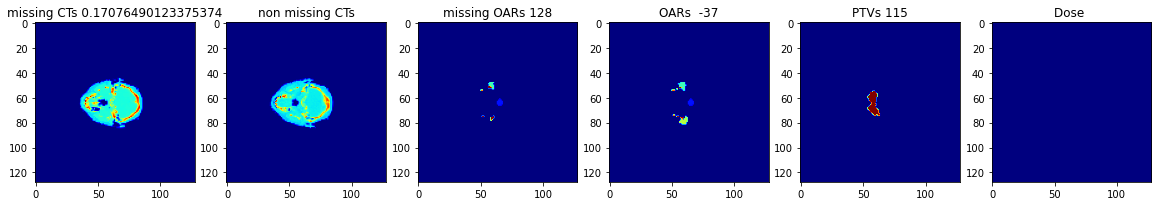

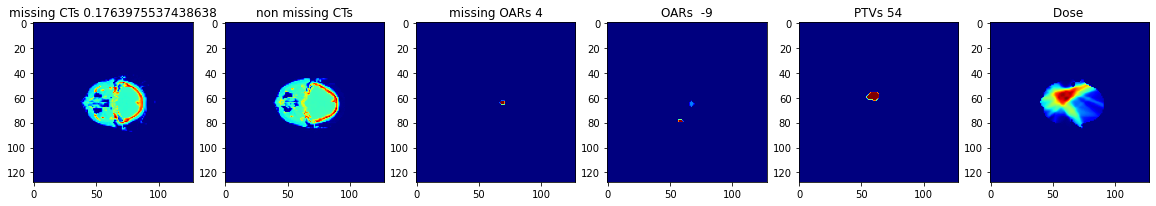

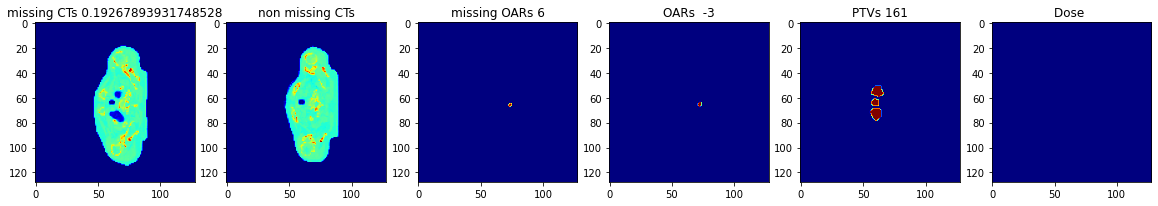

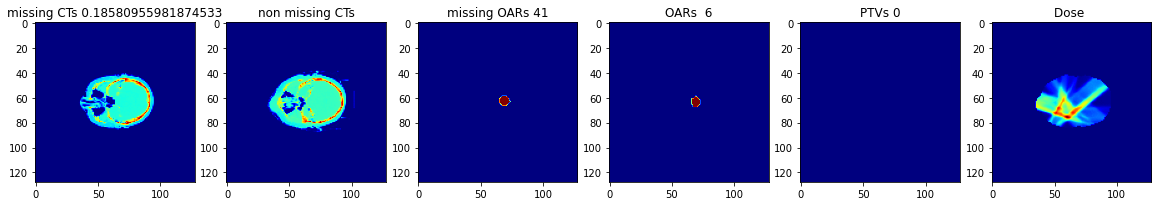

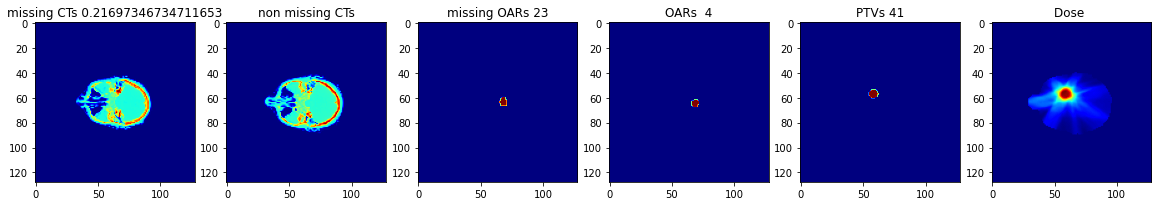

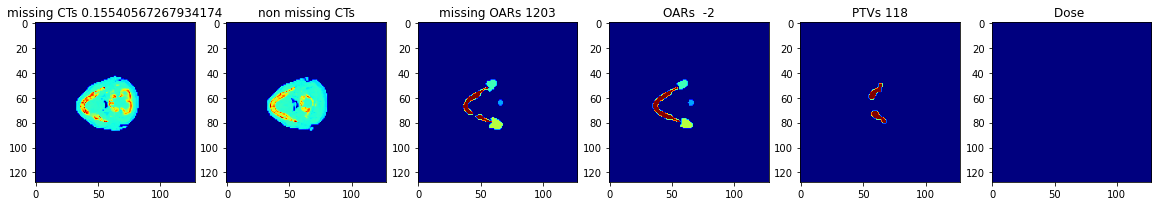

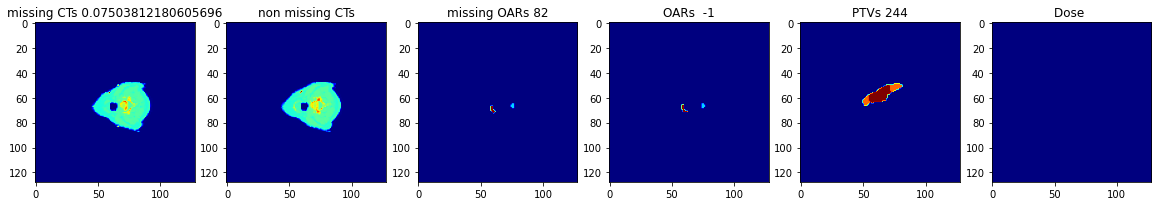

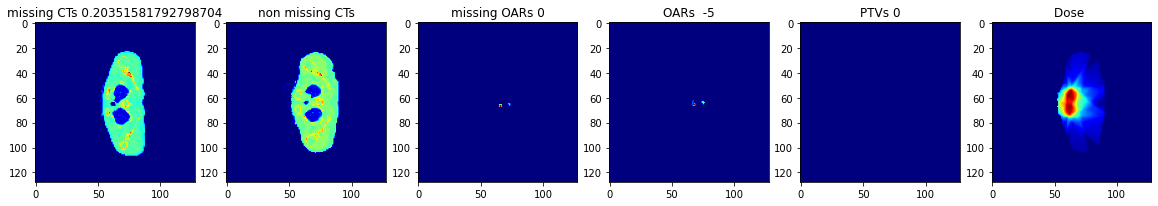

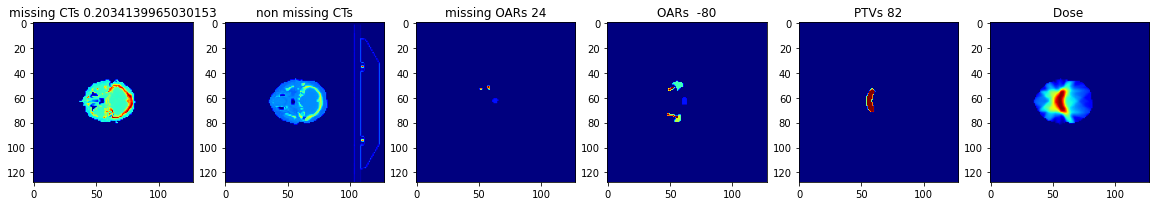

In [42]:
missing_paths = np.array(data_paths)[missing_indices]
non_missing_paths = np.array(data_paths)[mask]
for i,ind in enumerate(pairwise_distance.argmin(axis=1)):
    nmiss_imgs = read_data(non_missing_paths[ind])
    miss_imgs = read_data(missing_paths[i])

    fig, axs = plt.subplots(ncols=6, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    axs[0, 0].set_title(f"missing CTs {pairwise_distance[i, ind]}")
    axs[0, 0].imshow(miss_imgs[2], cmap='jet')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("non missing CTs")
    axs[0, 1].imshow(nmiss_imgs[2], cmap='jet')

    axs[0, 2].set_title(f"missing OARs {(miss_imgs[1][0]*(miss_imgs[1][0]==nmiss_imgs[1][0])).sum() }")
    axs[0, 2].imshow(miss_imgs[1][0], cmap='jet')

    axs[0, 3].set_title(f"OARs  {(miss_imgs[1][0]>0).sum()-(nmiss_imgs[1][0]>0).sum() }")
    axs[0, 3].imshow(nmiss_imgs[1][0], cmap='jet')

    axs[0, 4].set_title(f"PTVs {(nmiss_imgs[0]>0).sum()}")
    axs[0, 4].imshow(nmiss_imgs[0], cmap='jet')

    axs[0, 5].set_title(f"Dose ")
    axs[0, 5].imshow(nmiss_imgs[-1], cmap='jet')
    plt.show()

    

### Test the trained models

In [14]:
model = Model_sep(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
model.load_state_dict(torch.load(PATH,  map_location='cuda:1')['network_state_dict'])
model = model.eval()

model1 = Model(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256])
weights = torch.load(PATH1, map_location='cuda:1')['network_state_dict']
model1.load_state_dict(weights)
model1 = model1.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [7]:
#val (102, 1044)
#Test (99, 1054)
#Train (746, 6791)

### Validation

0it [00:00, ?it/s]

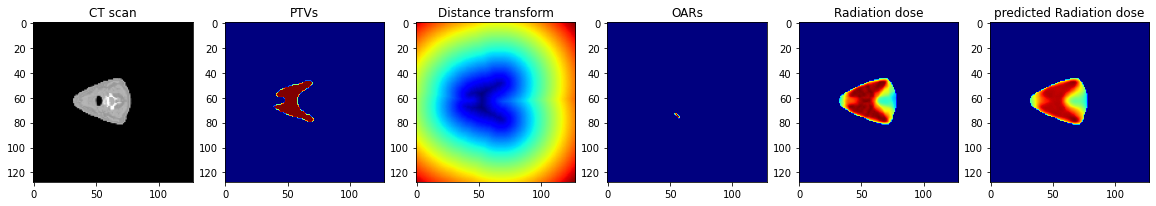

1it [00:00,  1.27it/s]

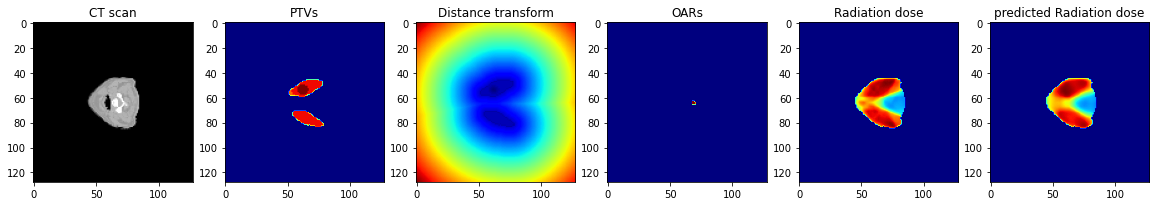

2it [00:01,  1.43it/s]

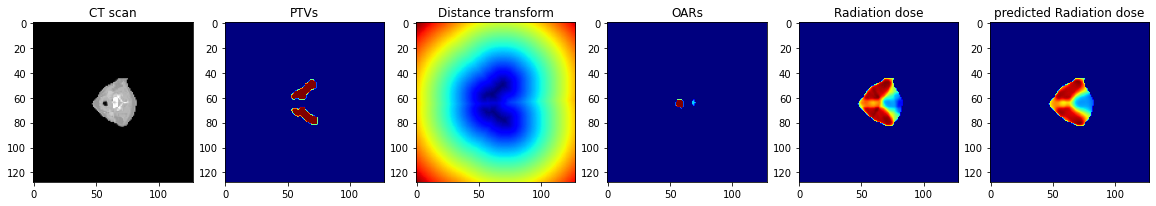

3it [00:01,  1.70it/s]

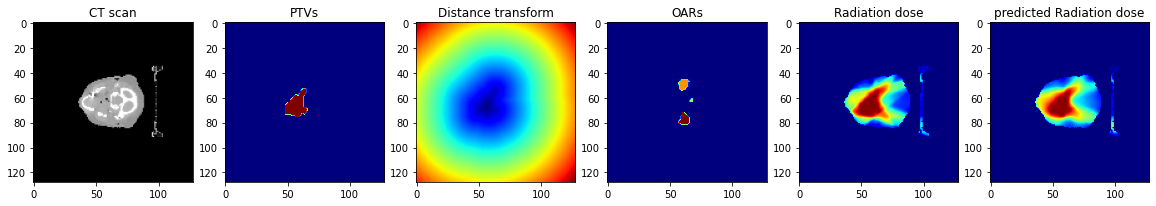

4it [00:02,  1.61it/s]

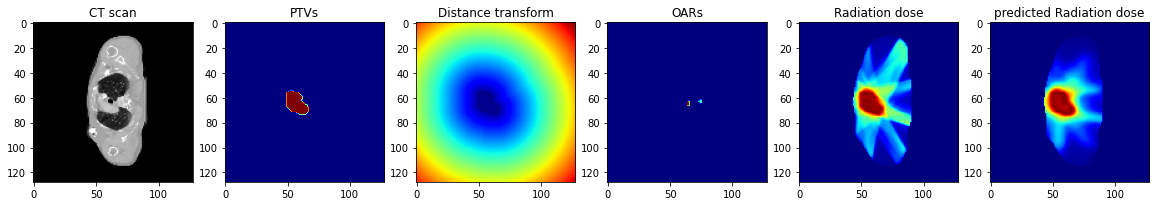

5it [00:02,  1.82it/s]

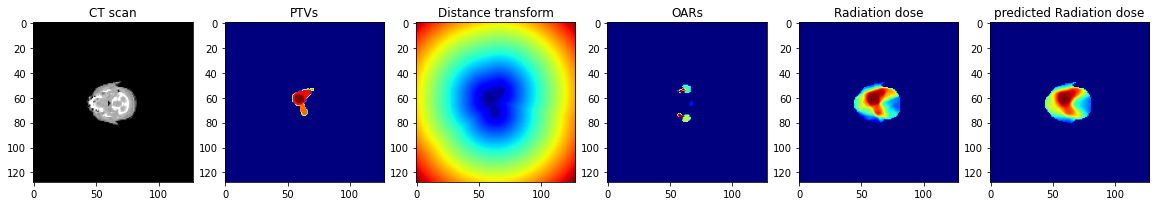

6it [00:03,  1.97it/s]

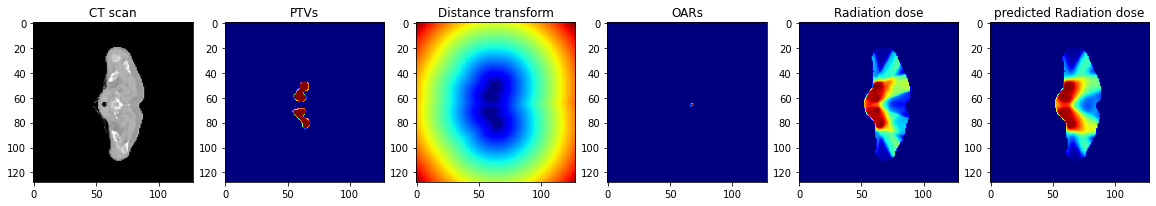

7it [00:03,  2.11it/s]

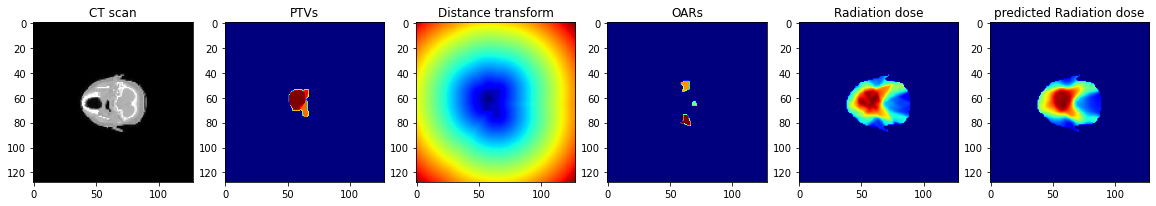

8it [00:04,  2.22it/s]

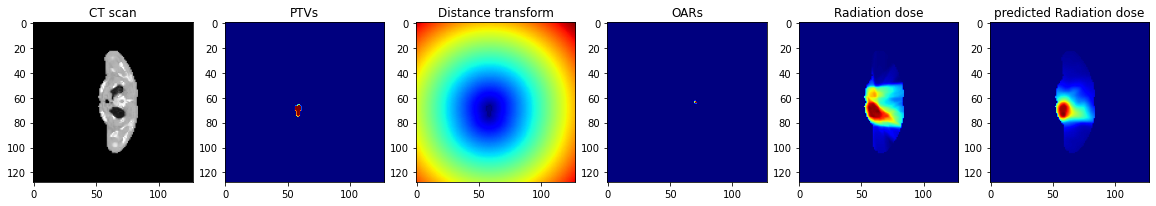

9it [00:04,  2.30it/s]

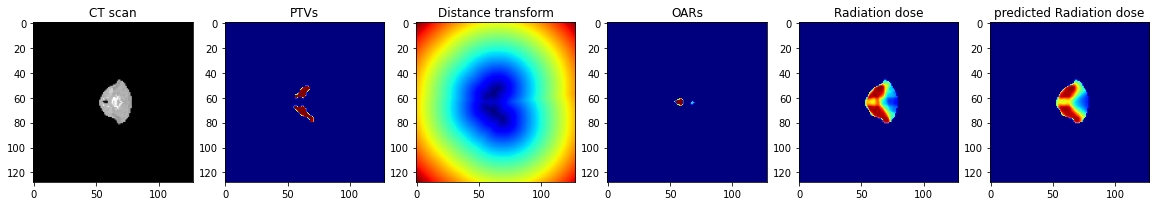

1200it [01:05, 18.23it/s]


In [15]:
from DCNN.loss import Loss, L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn= Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0][0]
    mask = list_loader_output[0]['data'][2][0][0]
    if input_[0][0].sum()!=0:
        output = model(input_)
        loss.append(float(loss_fn(output[0][0], [target, mask])))
        if batch_idx<10 and Visualize:
            show(list_loader_output[0]['data'], output[0][0].detach()[0]*mask)
    else:
        output = model1(input_)
        loss_artif.append(float(loss_fn(output[0][0], [target, mask])))
        if batch_idx<10 and Visualize:
            show(list_loader_output[0]['data'], output[0][0].detach()[0]*mask)
    
    
    

In [7]:
print(f'MAE of the predicted radiation dose in the validation set: %.3f' %np.mean(loss))

MAE of the predicted radiation dose in the validation set: 0.322


In [16]:
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(0.32178630615223425, 0.2509993371481198, 0.3145896309701493)

In [8]:
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(0.32178630615223425, 0.4619140233386491, 0.33603262406618645)

In [104]:
#DVHLoss1
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(0.37259540446772255, 0.43209439635271096, 0.37968570100068366)

In [98]:
#DVHLoss
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(nan, 0.4403352543412076, 0.4403352543412076)

### Testing

In [20]:
loss = []
loss_fn= nn.L1Loss(reduction='mean')

for batch_idx, list_loader_output in tqdm(enumerate(test)):
    path = list_loader_output[1][0]
    input_ = list_loader_output[0][0]
    target = list_loader_output[0][1][0,0]
    mask = list_loader_output[0][2][0][0]
    if input_[0][0].sum()!=0:
        output = model(input_)
        img_pred = (output[0][0,0]*mask).detach().numpy()
    else:
        output = model1(input_)
        img_pred = (output[0][0,0]*mask).detach().numpy()
    
    np.save(PATH_OUT + '/' + path.split('/')[-1], img_pred)        

1200it [01:06, 17.95it/s]
